### Regression Project - Analysis of External Factors that Impact Sales of a Retail Store

Objective

The objective of this study is to investigate how external factors such as holiday events, oil prices, public sectors wages and natural occurences, impact the sales of Corporation Favorita, a large Ecuadorian-based grocery retailer.

#### Introduction

Time series forecasting offers significant benefits across various industries and applications. It enables improved decision-making by providing valuable insights into future trends and patterns, helping organizations make more informed and data-driven decisions. Businesses can attain better inventory management, efficient supply chains, and improved customer satisfaction by accurately forecasting demand for products.

Time series forecasting can help identify opportunities for revenue growth, such as identifying high-demand products and optimal pricing strategies. Businesses can also use forecasts to plan marketing campaigns and promotions effectively.

#### Business/Data Understanding

In this project, I endeavor to predict store sales on data from Corporation Favorita, a large Ecuadorian-based grocery retailer. I aim to build a model that accurately predicts the unit sales for thousands of items sold at different Favorita stores. 

This is a supervised ML regression project with data from the years 2013 – 2017.

 The training data includes dates, store, and product information, whether that item was being promoted, as well as the sales numbers. The test data has all features present in the training data except for the target, sales.

 There are additional files that have supplementary information useful for building ML models. The key files are:-
 
   1. Oil.csv file had daily oil prices. Ecuador is an oil-dependent country, and its economic health is highly vulnerable to shocks in oil prices. 
 
  2. holidays_events.csv file had detailed descriptions of various types of holidays and events held in Ecuador. 
  
  3. Stores.csv file had store metadata, including city, state, type, and cluster. Cluster is a grouping of similar stores.

Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. Supermarket sales could be affected by this.

A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

**Questions**

1.  Is the train dataset complete (has all the required dates)?

2.  Which dates have the lowest and highest sales for each year?

3.  Did the earthquake impact sales?

4.  Are certain groups of stores selling more products? (Cluster, city,
    state, type)

5.  Are sales affected by promotions, oil prices and holidays?

6.  What analysis can we get from the date and its extractable features?

7.  What is the difference between RMSLE, RMSE, MSE (or why is the MAE
    greater than all of them?)

Formulate Hypotheses:

Null Hypothesis (H0): There is no significant difference in sales between products on promotion and products not on promotion.

Alternative Hypothesis (H1): There is a significant difference in sales between products on promotion and products not on promotion.

In [1]:
import pyodbc #just installed with pip
from dotenv import dotenv_values #import the dotenv_values function from the dotenv package
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from scipy import stats
import plotly.express as px
import numpy as np
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ParameterGrid
# saving model
import pickle
import os
import sys
sys.path.insert(0, r'C:\Users\WORLDAX COMPUTERS\Python Projects\STREAMLIT_PROJECT\myenv\lib\site-packages')
#inserting the virtual environment path at the beginning of sys.path, you ensure that Python prioritizes packages from the virtual environment

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')# Get the values for the credentials you set in the '.env' file
database=environment_variables.get("DATABASE")
server=environment_variables.get("SERVER")
username=environment_variables.get("USERNAME")
password=environment_variables.get("PASSWORD")

connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [3]:
# Use the connect method of the pyodbc library and pass in the connection string.
# This will connect to the server and might take a few seconds to be complete. 
# Check your internet connection if it takes more time than necessary

connection=pyodbc.connect(connection_string)

In [4]:
# Now the sql queries to get the data is what what you see below. 
# Note that you will not have permissions to insert delete or update this database table. 

query_1 = "Select * from dbo.oil"
query_2 = "Select * from dbo.holidays_events"
query_3 = "Select * from dbo.stores"

data_oil = pd.read_sql(query_1,connection)
holiday_data = pd.read_sql(query_2,connection)
store_data = pd.read_sql(query_3,connection)

In [5]:
# preview of first five rows of each dataframe using .head() method
#data_oil
data_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [6]:
#Rename the 'dcoilwtico' to 'Oil_prices"
data_oil.rename(columns={'dcoilwtico': 'Oil_prices'}, inplace=True)

In [7]:
#Check for duplicates
data_oil.duplicated().sum()

0

In [8]:
#holiday_data
holiday_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [9]:
#Check for duplicates
holiday_data.duplicated().sum()

0

In [10]:
#store_data
store_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [11]:
#Check for duplicates
store_data.duplicated().sum()

0

In [12]:
#saving copy of files in  .csv format
data_oil.to_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\oil_prices.csv')
holiday_data.to_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\holiday_data.csv')
store_data.to_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\store_data.csv')

In [13]:
#loading of datasets for review
oil_prices = pd.read_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\oil_prices.csv',parse_dates=['date'], index_col=0)
holiday_data = pd.read_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\holiday_data.csv',parse_dates=['date'], index_col=0)
store_nbr_data = pd.read_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\store_data.csv', index_col=0)

In [14]:
#preview of information summary in the dataframes using .info() method
#1.oil prices data
oil_prices.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   Oil_prices  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.5 KB


In [15]:
#Check of missing values in Holiday data
oil_prices.isna().sum()

date           0
Oil_prices    43
dtype: int64

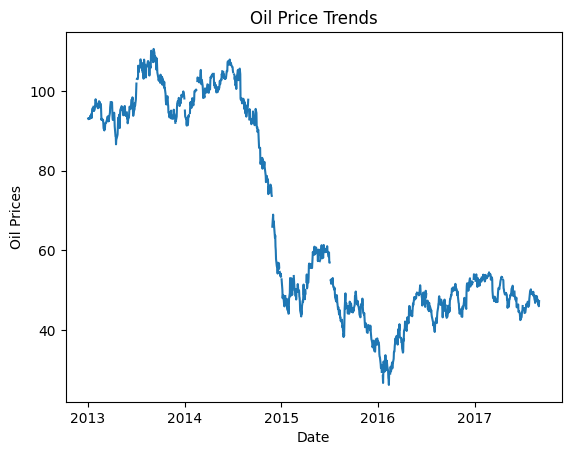

In [16]:
#Visual representation
#Broken regions on line represent missing values
plt.plot(oil_prices['date'], oil_prices['Oil_prices'])
plt.xlabel('Date')
plt.ylabel('Oil Prices')
plt.title('Oil Price Trends')
plt.show()

In [17]:
#2.Holiday_data 
holiday_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 16.7+ KB


In [18]:
holiday_data['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [19]:
#Check of missing values in Holiday data
holiday_data.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [20]:
# Grouping by 'type' and counting occurrences of each 'locale'
locale_counts = holiday_data.groupby('type')['locale'].count()
locale_counts

type
Additional     51
Bridge          5
Event          56
Holiday       221
Transfer       12
Work Day        5
Name: locale, dtype: int64

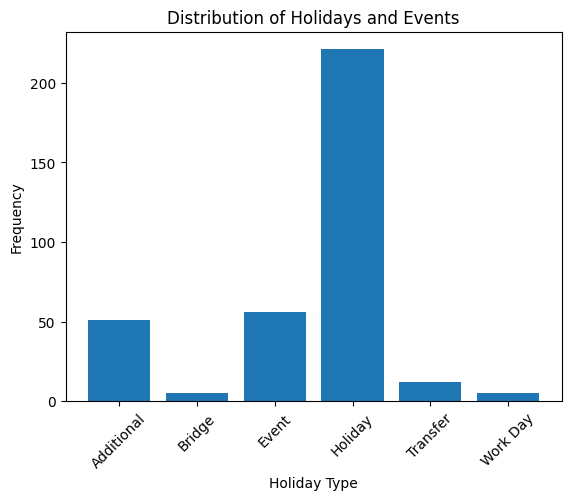

In [21]:
# Creating a bar plot
plt.bar(locale_counts.index, locale_counts.values)
plt.xlabel('Holiday Type')
plt.ylabel('Frequency')
plt.title('Distribution of Holidays and Events')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

In [22]:
# 3. Stores data
store_nbr_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.5+ KB


In [23]:
#Check of missing values in store_data
store_nbr_data.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

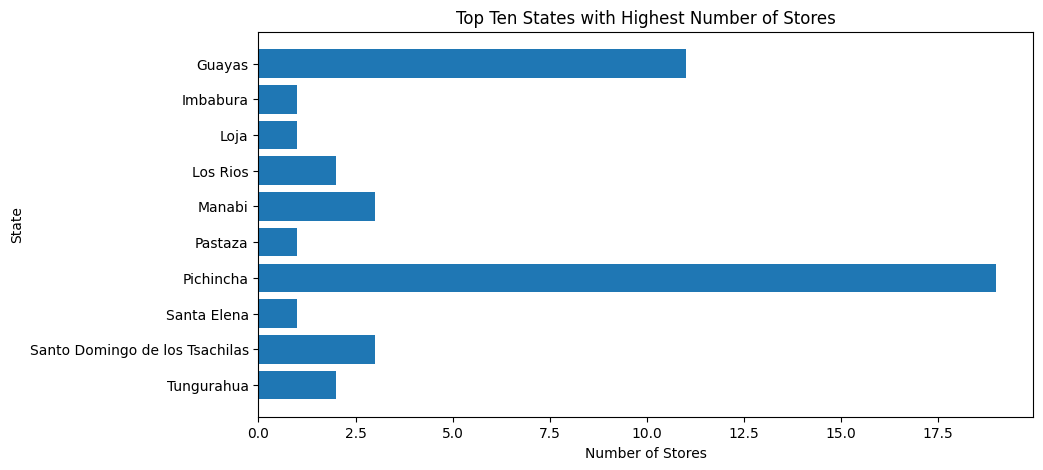

In [24]:
# Grouping by state and counting the number of stores
state_counts = store_nbr_data.groupby('state')['store_nbr'].count()

grouped_state_counts = state_counts.sort_index(ascending=False)

# Selecting the top ten states
top_ten_states = grouped_state_counts.head(10)

# Creating a horizontal bar plot for top ten states
plt.figure(figsize=(10, 5))
plt.barh(top_ten_states.index, top_ten_states.values)
plt.ylabel('State')
plt.xlabel('Number of Stores')
plt.title('Top Ten States with Highest Number of Stores')
plt.show()

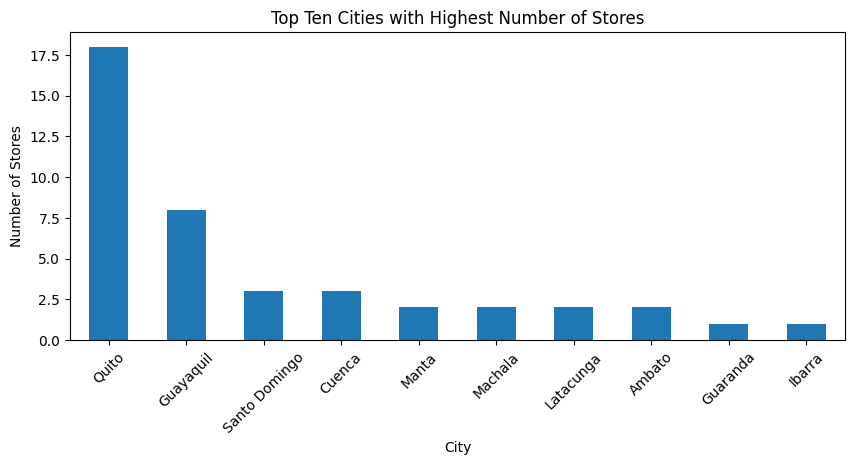

In [25]:
# Grouping by city and counting the number of stores
store_grouping = store_nbr_data.groupby('city')['store_nbr'].count()
store_grouping_sorted = store_grouping.sort_values(ascending=False)

# Selecting the top ten cities
top_ten_cities = store_grouping_sorted.head(10)

# Creating a bar plot for the top ten cities
plt.figure(figsize=(10, 4))
top_ten_cities.plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Number of Stores')
plt.title('Top Ten Cities with Highest Number of Stores')
plt.xticks(rotation=45)
plt.show()

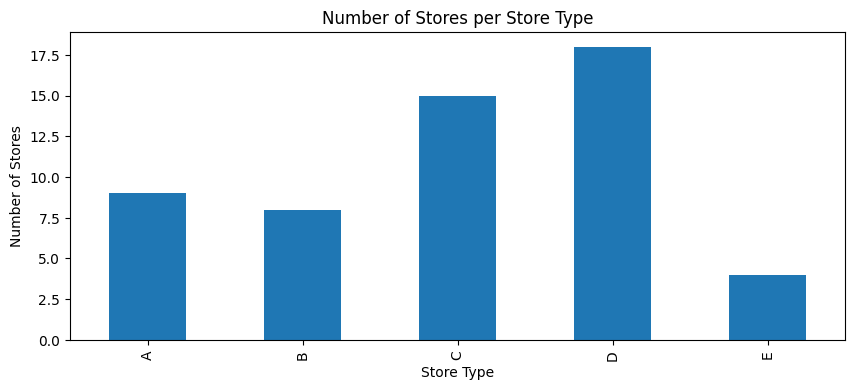

In [26]:
# Creating a bar plot of store count per type
plt.figure(figsize=(10, 4))
store_nbr_data['type'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Store Type')
plt.ylabel('Number of Stores')
plt.title('Number of Stores per Store Type')
#plt.xticks(rotation=45)
plt.show()

In [27]:
#transaction data
transaction_data = pd.read_csv(r"C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\transactions.csv", parse_dates=['date'], index_col='date')
#preview of information summary
transaction_data.info()                          

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83488 entries, 2013-01-01 to 2017-08-15
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   store_nbr     83488 non-null  int64
 1   transactions  83488 non-null  int64
dtypes: int64(2)
memory usage: 1.9 MB


In [28]:
#Any missing values in the transaction_data dataframe
transaction_data.isna().sum()

store_nbr       0
transactions    0
dtype: int64

In [29]:
# Grouping by store_nbr and summing the transactions
transactions_grouped = transaction_data.groupby('store_nbr')['transactions'].sum()
# Series contains the sum of transactions for each store number. 
# Sorting the results in descending order based on the sum of transactions
transactions_sorted = transactions_grouped.sort_values(ascending=False)
#Top ten stores with highest transactions
top_ten_stores = transactions_sorted.head(10)
#Creation of a dataframe table to ease visualization/understanding
top_ten_stores_per_transactions = top_ten_stores.reset_index()
top_ten_stores_per_transactions

,store_nbr,transactions
0,44,7273093
1,47,6535810
2,45,6201115
3,46,5990113
4,3,5366350
5,48,5107785
6,8,4637971
7,49,4574103
8,50,4384444
9,11,3972488


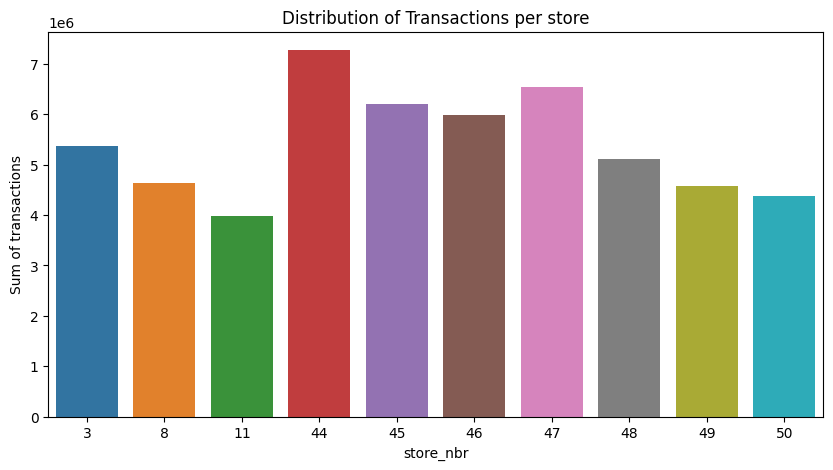

In [30]:
plt.figure(figsize=(10,5))
plt.xlabel('store number')
plt.ylabel('Sum of transactions')
plt.title('Distribution of Transactions per store')
sns.barplot(x=top_ten_stores.index, y=top_ten_stores.values)
plt.show()

In [31]:
#Loading of Train data set
train_data = pd.read_csv(r"C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\train.csv", parse_dates=['date'], index_col='date')
#Preview of first five rows
train_data.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [32]:
train_data.columns

Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [33]:
#Preview of information summary in train data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [34]:
#Check of missing values in train data
train_data.isna().sum()

id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [35]:
#Check of Duplicates
train_data.duplicated().sum()

0

In [36]:
#Loading of test data set
test_data = pd.read_csv(r"C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\test.csv", parse_dates=['date'], index_col='date')
#Preview of first five rows
test_data.head() 

,id,store_nbr,family,onpromotion
date,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0
2017-08-16,3000889,1,BABY CARE,0
2017-08-16,3000890,1,BEAUTY,2
2017-08-16,3000891,1,BEVERAGES,20
2017-08-16,3000892,1,BOOKS,0


In [37]:
#Preview of information summary in test data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28512 entries, 2017-08-16 to 2017-08-31
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   store_nbr    28512 non-null  int64 
 2   family       28512 non-null  object
 3   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


In [38]:
#Check of missing values in test data
test_data.isna().sum()

id             0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [39]:
#Check of Duplicates
test_data.duplicated().sum()

0

## Cleaning

Joining datasets

Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices

Slice of data from Date 2013-01-01 to 2013-01-07 in oil.csv(Daily oil price) 

Addition of the sliced oil prices data to the training set because they fall within same timeframe



In [40]:
start_date = pd.to_datetime('2013-01-01')

end_date = pd.to_datetime('2017-08-15')

#Use of Boolean indexing to slice data within the data range
sliced_df1 =oil_prices[(oil_prices['date'] >= start_date) & (oil_prices['date'] <= end_date)]

sliced_df1

,date,Oil_prices
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997
...,...,...
1201,2017-08-09,49.590000
1202,2017-08-10,48.540001
1203,2017-08-11,48.810001
1204,2017-08-14,47.590000


Concatanation of oil prices (sliced_df_1) to the training data set

In [41]:
# Merge the two DataFrames based on the 'date' column
#The how='left' argument specifies that you want to keep all rows from the left DataFrame (train_data), 
#and match them with rows from the right DataFrame (sliced_df1) based on the 'date' column.

merged_train_data = train_data.merge(sliced_df1, on='date', how='left')

#preview of merged train data
merged_train_data.tail(5)

,date,id,store_nbr,family,sales,onpromotion,Oil_prices
3000883,2017-08-15,3000883,9,POULTRY,438.133,0,47.57
3000884,2017-08-15,3000884,9,PREPARED FOODS,154.553,1,47.57
3000885,2017-08-15,3000885,9,PRODUCE,2419.729,148,47.57
3000886,2017-08-15,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57
3000887,2017-08-15,3000887,9,SEAFOOD,16.000,0,47.57


Addition of store.csv medata and transaction data to both the training and testing data

Merging will be based on the similar column in the dataframes

Merging of store.csv with train_data based on column 'store number'

In [42]:
#Check of unique values in store number column of merged_train_data
merged_train_data['store_nbr'].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9], dtype=int64)

In [43]:
# check of  unique values in store number column of store dataframe
store_data['store_nbr'].unique()


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54], dtype=int64)

In [44]:
# Merge the two DataFrames based on the 'store number' column
merged_train_data2 = merged_train_data.merge(store_data, on='store_nbr', how='left')

#preview of the merged train data
merged_train_data2.tail(5)

,date,id,store_nbr,family,sales,onpromotion,Oil_prices,city,state,type,cluster
3000883,2017-08-15,3000883,9,POULTRY,438.133,0,47.57,Quito,Pichincha,B,6
3000884,2017-08-15,3000884,9,PREPARED FOODS,154.553,1,47.57,Quito,Pichincha,B,6
3000885,2017-08-15,3000885,9,PRODUCE,2419.729,148,47.57,Quito,Pichincha,B,6
3000886,2017-08-15,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Quito,Pichincha,B,6
3000887,2017-08-15,3000887,9,SEAFOOD,16.000,0,47.57,Quito,Pichincha,B,6


Merging of transaction data to the training set based on two similar columns, namely, 'date', and 'store_nbr'

Addition of this column is just for analysis purposes, it will be dropped from the training data before modelling.

In [45]:
merged_train_dataset3 = merged_train_data2.merge(transaction_data, on=['date', 'store_nbr'], how='left')

#Preview of changes made to training data
merged_train_dataset3.tail(5)

,date,id,store_nbr,family,sales,onpromotion,Oil_prices,city,state,type,cluster,transactions
3000883,2017-08-15,3000883,9,POULTRY,438.133,0,47.57,Quito,Pichincha,B,6,2155.0
3000884,2017-08-15,3000884,9,PREPARED FOODS,154.553,1,47.57,Quito,Pichincha,B,6,2155.0
3000885,2017-08-15,3000885,9,PRODUCE,2419.729,148,47.57,Quito,Pichincha,B,6,2155.0
3000886,2017-08-15,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Quito,Pichincha,B,6,2155.0
3000887,2017-08-15,3000887,9,SEAFOOD,16.000,0,47.57,Quito,Pichincha,B,6,2155.0


In [46]:
#check for duplicates
merged_train_dataset3.duplicated().sum()

0

Merging "Holiday Data" to the "merged_train_dataset" on similar column, "date"

In [47]:
#Preview of Holiday_data 'date' column
holiday_data['date']

0     2012-03-02
1     2012-04-01
2     2012-04-12
3     2012-04-14
4     2012-04-21
         ...    
345   2017-12-22
346   2017-12-23
347   2017-12-24
348   2017-12-25
349   2017-12-26
Name: date, Length: 350, dtype: datetime64[ns]

In [48]:
#Choose of date range in 'holiday_data' column that falls within the train data set 

start_date1 = pd.to_datetime('2013-01-01')

end_date1 = pd.to_datetime('2017-08-15')

#Use of Boolean indexing to slice data within the data range
holiday_data_range =holiday_data[(holiday_data['date'] >= start_date1) & (holiday_data['date'] <= end_date1)]
#Preview of changes to dataframe
holiday_data_range['date']

41    2013-01-01
42    2013-01-05
43    2013-01-12
44    2013-02-11
45    2013-02-12
         ...    
322   2017-07-25
323   2017-08-05
324   2017-08-10
325   2017-08-11
326   2017-08-15
Name: date, Length: 286, dtype: datetime64[ns]

In [49]:

merged_train_dataset4 = merged_train_dataset3.merge(holiday_data_range, on='date', how='left')

#Preview of new changes made to training data
merged_train_dataset4.head(5)

,date,id,store_nbr,family,sales,onpromotion,Oil_prices,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred
0,2013-01-01,0,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,1,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,2,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,3,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,4,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [50]:
#Renaming of 'type_y' column to 'holiday_types' for easy understanding

merged_train_dataset = merged_train_dataset4.rename(columns={'type_y': 'holiday_types', 'type_x':'type'})
#Preview of changes 
merged_train_dataset.columns

Index(['date', 'id', 'store_nbr', 'family', 'sales', 'onpromotion',
       'Oil_prices', 'city', 'state', 'type', 'cluster', 'transactions',
       'holiday_types', 'locale', 'locale_name', 'description', 'transferred'],
      dtype='object')

In [51]:
#A look of unique values in "type_y" column
merged_train_dataset['holiday_types'].unique()

array(['Holiday', nan, 'Work Day', 'Additional', 'Event', 'Transfer',
       'Bridge'], dtype=object)

In [52]:
#A look of unique values in "type_x" column
merged_train_dataset['type'].unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

Creation of new column features from 'date' column, namely, 'day', 'Month', and 'year' in train dataset

In [53]:
#Creation of new "year" column
merged_train_dataset['year'] = merged_train_dataset['date'].dt.year

#Creation of new "month" column
merged_train_dataset['month'] = merged_train_dataset['date'].dt.month

#Creation of new "day" column
merged_train_dataset['day_of_month'] = merged_train_dataset['date'].dt.day

#Creation of "day of the week" column
merged_train_dataset['day_of_week'] = merged_train_dataset['date'].dt.day_name()

In [54]:
#shape of the modified train dataset
merged_train_dataset.shape

(3054348, 21)

In [55]:
merged_train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 21 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   id             int64         
 2   store_nbr      int64         
 3   family         object        
 4   sales          float64       
 5   onpromotion    int64         
 6   Oil_prices     float64       
 7   city           object        
 8   state          object        
 9   type           object        
 10  cluster        int64         
 11  transactions   float64       
 12  holiday_types  object        
 13  locale         object        
 14  locale_name    object        
 15  description    object        
 16  transferred    object        
 17  year           int32         
 18  month          int32         
 19  day_of_month   int32         
 20  day_of_week    object        
dtypes: datetime64[ns](1), float64(3), int32(3), int64(4), object(10)
memory usage

Check for completeness of dates

In [56]:
#set date as index in train dataset
merged_train_dataset.set_index('date', inplace=True)

In [57]:
#Recorded number of days
unique_dates = merged_train_dataset.index.nunique()
unique_dates

1684

In [58]:
#Expected working dates
expected_dates = pd.date_range(start=merged_train_dataset.index.min(), end=merged_train_dataset.index.max())

print(expected_dates)

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')


In [59]:
# difference between expected_dates and the provide dates gives missing dates
missing_dates = set(expected_dates) - set(merged_train_dataset.index.unique())

#print.. the missing dates
missing_dates

{Timestamp('2013-12-25 00:00:00'),
 Timestamp('2014-12-25 00:00:00'),
 Timestamp('2015-12-25 00:00:00'),
 Timestamp('2016-12-25 00:00:00')}

In [60]:
# Convert the set of missing dates to a list

missing_dates_list = list(missing_dates)

# Create a new DataFrame with the missing dates as the index
missing_df = pd.DataFrame(index=missing_dates_list)

# Concatenate the missing_df with the existing DataFrame
new_data = pd.concat([merged_train_dataset, missing_df])

new_data.sort_index(inplace=True)

In [61]:
#Create a copy for continued cleaning
merged_train_dataset = new_data.copy()

In [62]:
#Missing dates are due to the added new dates
#Check for duplicates in train dataset

duplicated_rows = merged_train_dataset[merged_train_dataset.duplicated()]
print(duplicated_rows)

            id  store_nbr family  sales  onpromotion  Oil_prices city state  \
2014-12-25 NaN        NaN    NaN    NaN          NaN         NaN  NaN   NaN   
2015-12-25 NaN        NaN    NaN    NaN          NaN         NaN  NaN   NaN   
2016-12-25 NaN        NaN    NaN    NaN          NaN         NaN  NaN   NaN   

           type  cluster  transactions holiday_types locale locale_name  \
2014-12-25  NaN      NaN           NaN           NaN    NaN         NaN   
2015-12-25  NaN      NaN           NaN           NaN    NaN         NaN   
2016-12-25  NaN      NaN           NaN           NaN    NaN         NaN   

           description transferred  year  month  day_of_month day_of_week  
2014-12-25         NaN         NaN   NaN    NaN           NaN         NaN  
2015-12-25         NaN         NaN   NaN    NaN           NaN         NaN  
2016-12-25         NaN         NaN   NaN    NaN           NaN         NaN  


Filling up the missing dates in the 'year', 'month', 'day_of_month', and 'day_of_week' columns

In [63]:
# Iterate through the missing dates
for missing_date in missing_dates:
    # Extract year, month, day, and day_of_week from the missing date
    year = missing_date.year
    month = missing_date.month
    day_of_month = missing_date.day
    day_of_week = missing_date.day_of_week
    
    # Update the corresponding rows in the DataFrame with the extracted values
    merged_train_dataset.loc[missing_date, 'year'] = year
    merged_train_dataset.loc[missing_date, 'month'] = month
    merged_train_dataset.loc[missing_date, 'day_of_month'] = day_of_month
    merged_train_dataset.loc[missing_date, 'day_of_week'] = day_of_week

In [64]:
#Any Missing datetime values in the modified train dataset
merged_train_dataset.isna().sum()

id                     4
store_nbr              4
family                 4
sales                  4
onpromotion            4
Oil_prices        955156
city                   4
state                  4
type                   4
cluster                4
transactions      249121
holiday_types    2551828
locale           2551828
locale_name      2551828
description      2551828
transferred      2551828
year                   0
month                  0
day_of_month           0
day_of_week            0
dtype: int64

Similar changes will be made to the test dataset as were done to train set

Slice of data from Date 2017-08-16 to 2017-08-31 in oil.csv(Daily oil price) 

Addition of the sliced oil prices data to the test set because they fall within same timeframe

In [65]:
start_date1 = pd.to_datetime('2017-08-16')

end_date1 = pd.to_datetime('2017-08-31')

#Use of Boolean indexing to slice data within the data range
sliced_df2 =oil_prices[(oil_prices['date'] >= start_date1) & (oil_prices['date'] <= end_date1)]

#Preview of sliced data
sliced_df2

,date,Oil_prices
1206,2017-08-16,46.799999
1207,2017-08-17,47.070000
1208,2017-08-18,48.590000
1209,2017-08-21,47.389999
1210,2017-08-22,47.650002
1211,2017-08-23,48.450001
1212,2017-08-24,47.240002
1213,2017-08-25,47.650002
1214,2017-08-28,46.400002
1215,2017-08-29,46.459999


Concatanation of oil prices in sliced_df2 to the test data set

In [66]:
# Merge the two DataFrames based on the 'date' column
merged_test_data = test_data.merge(sliced_df2, on='date', how='left')

#preview of merged train data
merged_test_data.tail(5)

,date,id,store_nbr,family,onpromotion,Oil_prices
28507,2017-08-31,3029395,9,POULTRY,1,47.259998
28508,2017-08-31,3029396,9,PREPARED FOODS,0,47.259998
28509,2017-08-31,3029397,9,PRODUCE,1,47.259998
28510,2017-08-31,3029398,9,SCHOOL AND OFFICE SUPPLIES,9,47.259998
28511,2017-08-31,3029399,9,SEAFOOD,0,47.259998


In [67]:
# Merging of store.csv data with the test_data based on column 'store number'
# Merge the two DataFrames based on the 'store number' column
merged_test_data2 = merged_test_data.merge(store_data, on='store_nbr', how='left')

#preview of the merged train data
merged_test_data2.tail(5)

,date,id,store_nbr,family,onpromotion,Oil_prices,city,state,type,cluster
28507,2017-08-31,3029395,9,POULTRY,1,47.259998,Quito,Pichincha,B,6
28508,2017-08-31,3029396,9,PREPARED FOODS,0,47.259998,Quito,Pichincha,B,6
28509,2017-08-31,3029397,9,PRODUCE,1,47.259998,Quito,Pichincha,B,6
28510,2017-08-31,3029398,9,SCHOOL AND OFFICE SUPPLIES,9,47.259998,Quito,Pichincha,B,6
28511,2017-08-31,3029399,9,SEAFOOD,0,47.259998,Quito,Pichincha,B,6


In [68]:
# Merging of transaction data to the test set based on two similar columns, namely, 'date', and 'store_nbr'
merged_test_data3 = merged_test_data2.merge(transaction_data, on=['date', 'store_nbr'], how='left')

#Preview of changes made to training data
merged_test_data3.tail(5)

,date,id,store_nbr,family,onpromotion,Oil_prices,city,state,type,cluster,transactions
28507,2017-08-31,3029395,9,POULTRY,1,47.259998,Quito,Pichincha,B,6,NaN
28508,2017-08-31,3029396,9,PREPARED FOODS,0,47.259998,Quito,Pichincha,B,6,NaN
28509,2017-08-31,3029397,9,PRODUCE,1,47.259998,Quito,Pichincha,B,6,NaN
28510,2017-08-31,3029398,9,SCHOOL AND OFFICE SUPPLIES,9,47.259998,Quito,Pichincha,B,6,NaN
28511,2017-08-31,3029399,9,SEAFOOD,0,47.259998,Quito,Pichincha,B,6,NaN


In [69]:
merged_test_data3.isna().sum()

date                0
id                  0
store_nbr           0
family              0
onpromotion         0
Oil_prices       7128
city                0
state               0
type                0
cluster             0
transactions    28512
dtype: int64

Merging "Holiday Data" to the "merged_test_dataset" on similar column, "date"

In [70]:
#Choose of date range in 'holiday_data' column that falls within the train data set 

start_date1 = pd.to_datetime('2017-08-16')

end_date2 = pd.to_datetime('2017-08-31')

#Use of Boolean indexing to slice data within the data range
holiday_data_range2 =holiday_data[(holiday_data['date'] >= start_date1) & (holiday_data['date'] <= end_date2)]

In [71]:
merged_test_data4 = merged_test_data3.merge(holiday_data_range2, on='date', how='left')


#Preview of new changes made to training data
merged_test_data4.tail(3)

,date,id,store_nbr,family,onpromotion,Oil_prices,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred
28509,2017-08-31,3029397,9,PRODUCE,1,47.259998,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN
28510,2017-08-31,3029398,9,SCHOOL AND OFFICE SUPPLIES,9,47.259998,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN
28511,2017-08-31,3029399,9,SEAFOOD,0,47.259998,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
#Renaming of 'type_y' column to 'holiday_types' for easy understanding

merged_test_dataset = merged_test_data4.rename(columns={'type_y': 'holiday_types', 'type_x':'type'})
#Preview of changes 
merged_train_dataset.columns

Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion', 'Oil_prices',
       'city', 'state', 'type', 'cluster', 'transactions', 'holiday_types',
       'locale', 'locale_name', 'description', 'transferred', 'year', 'month',
       'day_of_month', 'day_of_week'],
      dtype='object')

Creation of new column features from 'date' column, namely, 'day', 'Month', and 'year' in test dataset

In [73]:
#Creation of new "year" column
merged_test_dataset['year'] = merged_test_dataset['date'].dt.year

#Creation of new "month" column
merged_test_dataset['month'] = merged_test_dataset['date'].dt.month

#Creation of new "day" column
merged_test_dataset['day_of_month'] = merged_test_dataset['date'].dt.day

#Creation of "day of the week" column
merged_test_dataset['day_of_week'] = merged_test_dataset['date'].dt.day_name()

In [74]:
#Check for Duplicate values
merged_test_dataset.duplicated().sum()

0

In [75]:
#shape of the modified test dataset
merged_test_dataset.shape

(28512, 20)

In [76]:
merged_test_dataset.isna().sum()

date                 0
id                   0
store_nbr            0
family               0
onpromotion          0
Oil_prices        7128
city                 0
state                0
type                 0
cluster              0
transactions     28512
holiday_types    26730
locale           26730
locale_name      26730
description      26730
transferred      26730
year                 0
month                0
day_of_month         0
day_of_week          0
dtype: int64

### Handling Missing values in the combined datasets



Train dataset

In [77]:
#Preview on information summary on modified merged train dataset
merged_train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3054352 entries, 2013-01-01 to 2017-08-15
Data columns (total 20 columns):
 #   Column         Dtype  
---  ------         -----  
 0   id             float64
 1   store_nbr      float64
 2   family         object 
 3   sales          float64
 4   onpromotion    float64
 5   Oil_prices     float64
 6   city           object 
 7   state          object 
 8   type           object 
 9   cluster        float64
 10  transactions   float64
 11  holiday_types  object 
 12  locale         object 
 13  locale_name    object 
 14  description    object 
 15  transferred    object 
 16  year           float64
 17  month          float64
 18  day_of_month   float64
 19  day_of_week    object 
dtypes: float64(10), object(10)
memory usage: 521.6+ MB


In [78]:
#Summary of numerical description on modified training data
merged_train_dataset.describe()

,id,store_nbr,sales,onpromotion,Oil_prices,cluster,transactions,year,month,day_of_month
count,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,2.099196e+06,3.054348e+06,2.805231e+06,3.054352e+06,3.054352e+06,3.054352e+06
mean,1.504277e+06,2.750000e+01,3.590209e+02,2.617480e+00,6.801587e+01,8.481481e+00,1.697071e+03,2.014842e+03,6.222878e+00,1.565696e+01
std,8.662610e+05,1.558579e+01,1.107286e+03,1.225494e+01,2.569134e+01,4.649735e+00,9.668317e+02,1.345607e+00,3.374256e+00,8.801398e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.619000e+01,1.000000e+00,5.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00
25%,7.546768e+05,1.400000e+01,0.000000e+00,0.000000e+00,4.641000e+01,4.000000e+00,1.046000e+03,2.014000e+03,3.000000e+00,8.000000e+00
50%,1.507572e+06,2.750000e+01,1.100000e+01,0.000000e+00,5.343000e+01,8.500000e+00,1.395000e+03,2.015000e+03,6.000000e+00,1.600000e+01
75%,2.255120e+06,4.100000e+01,1.960110e+02,0.000000e+00,9.581000e+01,1.300000e+01,2.081000e+03,2.016000e+03,9.000000e+00,2.300000e+01
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02,1.106200e+02,1.700000e+01,8.359000e+03,2.017000e+03,1.200000e+01,3.100000e+01


In [79]:
#Check of missing values in modified train data set
print('-*Missing values in train dataset*-')
print('**' * 16)
for column in merged_train_dataset.columns:
    missin_vals = merged_train_dataset[column].isna().sum()
    print(f'Sum of missing values in column {column}: {missin_vals}') 

-*Missing values in train dataset*-
********************************
Sum of missing values in column id: 4
Sum of missing values in column store_nbr: 4
Sum of missing values in column family: 4
Sum of missing values in column sales: 4
Sum of missing values in column onpromotion: 4
Sum of missing values in column Oil_prices: 955156
Sum of missing values in column city: 4
Sum of missing values in column state: 4
Sum of missing values in column type: 4
Sum of missing values in column cluster: 4
Sum of missing values in column transactions: 249121
Sum of missing values in column holiday_types: 2551828
Sum of missing values in column locale: 2551828
Sum of missing values in column locale_name: 2551828
Sum of missing values in column description: 2551828
Sum of missing values in column transferred: 2551828
Sum of missing values in column year: 0
Sum of missing values in column month: 0
Sum of missing values in column day_of_month: 0
Sum of missing values in column day_of_week: 0


missing values in Oil_prices column

In [80]:
#Numerical description of oil prices column 
merged_train_dataset['Oil_prices'].describe()

count    2.099196e+06
mean     6.801587e+01
std      2.569134e+01
min      2.619000e+01
25%      4.641000e+01
50%      5.343000e+01
75%      9.581000e+01
max      1.106200e+02
Name: Oil_prices, dtype: float64

Interpolation can be a more sophisticated way to fill missing values, especially in time series data or other sequential data, as it considers the values around the missing data points to estimate a reasonable value.
It takes into account the relationships between data points for a more informed estimate of missing values.

Use of interpolation to fill NAN values in train_dataset

In [81]:
# Use interpolation to fill missing values in the specified column
merged_train_dataset['Oil_prices'] = merged_train_dataset['Oil_prices'].interpolate(method='time')

In [82]:
# Any Missing values in 'Oil_prices' column after interpolation? A few Missing values remaining

print(f'Missing values in Oil_prices column after interpolation:',merged_train_dataset['Oil_prices'].isna().sum())

Missing values in Oil_prices column after interpolation: 1782


Use of backward fill to replace remaining NAN values in "oil_prices" column

In [83]:
merged_train_dataset['Oil_prices'].fillna(method='bfill', inplace=True)

In [84]:
# Any remaining Missing values in 'Oil_prices' column after Using backward fill (bfill) 

print(f'Missing values in Oil_prices column after Using backward fill (bfill) :',merged_train_dataset['Oil_prices'].isna().sum())

Missing values in Oil_prices column after Using backward fill (bfill) : 0


missing values in 'holiday_types' column

Filling missing values in 'holiday_types' columnn of train dataset with "Not_a_Holiday"

This is because there are days that were not holdays and product sales are affected by Holidays

Similar changes will be effected to the test dataset

In [85]:
#Filling missing values in 'holiday_types' column of train dataset with 'Not a Holiday'
merged_train_dataset['holiday_types'].fillna('Not a Holiday', inplace=True)

#Missing values in 'transferred' column

The missing values are a result of the additional category "Not a Holiday" in the 'holiday_types' column

Decide to impute missing values with "False" because a non existent holiday cannot be transffered to another date.

In [86]:
#Filling missing values in 'transferred' column of train dataset with 'False'
merged_train_dataset['transferred'].fillna('False', inplace=True)

In [87]:
#Check missing values in remaining columns
merged_train_dataset.isna().sum()

id                     4
store_nbr              4
family                 4
sales                  4
onpromotion            4
Oil_prices             0
city                   4
state                  4
type                   4
cluster                4
transactions      249121
holiday_types          0
locale           2551828
locale_name      2551828
description      2551828
transferred            0
year                   0
month                  0
day_of_month           0
day_of_week            0
dtype: int64

In [88]:
#Used backward fill to impute missing values
# Impute missing values in specific columns using backward fill
columns_to_fill = ['id', 'store_nbr', 'family', 'onpromotion', 'city', 'type', 'cluster', 'transactions', 'locale', 'locale_name', 'description', 'state', 'sales', 'Oil_prices']  
merged_train_dataset[columns_to_fill] = merged_train_dataset[columns_to_fill].fillna(method='bfill')

In [89]:
#Check for any remaining missing values
merged_train_dataset.isna().sum()

id               0
store_nbr        0
family           0
sales            0
onpromotion      0
Oil_prices       0
city             0
state            0
type             0
cluster          0
transactions     0
holiday_types    0
locale           0
locale_name      0
description      0
transferred      0
year             0
month            0
day_of_month     0
day_of_week      0
dtype: int64

In [90]:
#Saving a copy of combined train set for powerbi visualization
merged_train_dataset.to_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\merged_train_dataset_BI.csv')


## Correlation Analysis

Calculate the correlation between numerical features and the target variable (sales). Use the corr method in pandas

In [91]:
#Select features with high absolute correlation values, as they are likely to have a stronger influence on the target variable.

# Select only numerical columns
numerical_columns = merged_train_dataset.select_dtypes(include=['number'])

# Calculate the correlation matrix for numerical columns
correlation_matrix = numerical_columns.corr()

relevant_features = correlation_matrix['sales'].sort_values(ascending=False)
relevant_features

sales           1.000000
onpromotion     0.428241
transactions    0.214919
id              0.086101
year            0.081320
store_nbr       0.041273
cluster         0.038537
month           0.020249
day_of_month   -0.011972
Oil_prices     -0.075570
Name: sales, dtype: float64

Visualization of correlation

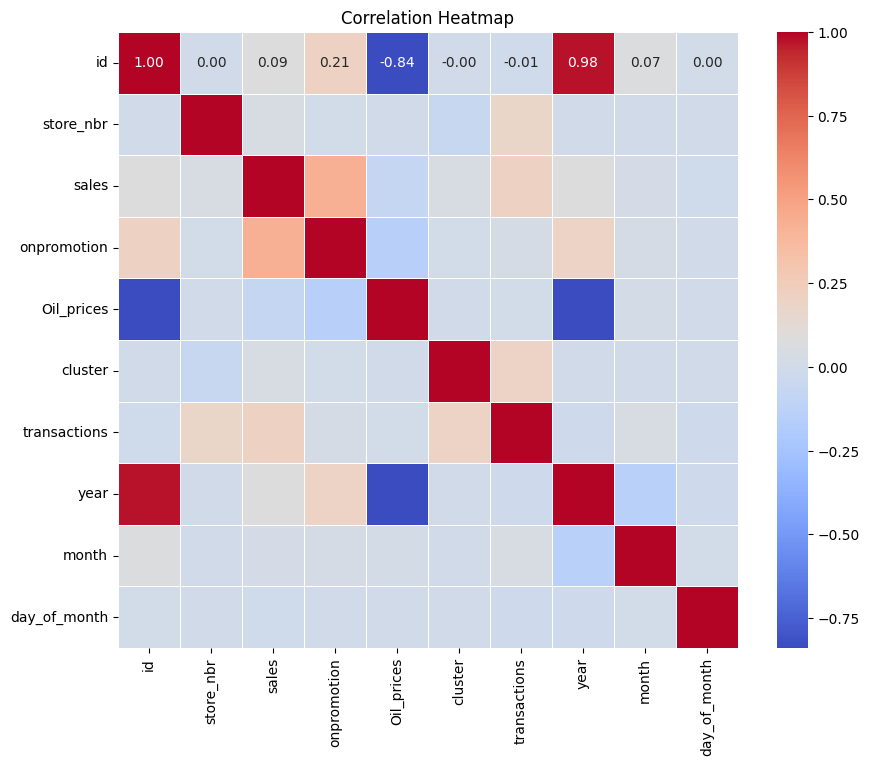

In [92]:
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

The heatmap shows that Onpromotion has the highest correlation to sales amongst all columns. This depicts that promotions is ideal to increase sales. This is followed by transactions, and obviously more transactions will lead to increased sales. Interestingly, Oil prices has a high negative correlation that some other columns, this are 'store_nbr', 'cluster', 'month' and 'day', meaning oil prices negatively impact daily sales.

Dropping of unnecessary columns(features) that don't have any contribution to the sales, the target

Decided to drop transactions column because it was missing in test dataset; we cannot have transactions without predicted sales target

Dropped "cluster" because it has low correlation to sales

Dropped "id" for it had low information value

Dropped 'locale', 'locale_name', and 'description' for they had large number of missing values and I had no clear strategy of imputing them.


In [93]:
merged_train_dataset = merged_train_dataset.drop(columns=['type', 'cluster', 'locale', 'locale_name', 'description', 'id', 'transactions'], axis=1,)
#A look at remaining columns
merged_train_dataset.columns

Index(['store_nbr', 'family', 'sales', 'onpromotion', 'Oil_prices', 'city',
       'state', 'holiday_types', 'transferred', 'year', 'month',
       'day_of_month', 'day_of_week'],
      dtype='object')

In [94]:
#Any missing values? None
merged_train_dataset.isna().sum()

store_nbr        0
family           0
sales            0
onpromotion      0
Oil_prices       0
city             0
state            0
holiday_types    0
transferred      0
year             0
month            0
day_of_month     0
day_of_week      0
dtype: int64

In [95]:
#shape of dataframe
merged_train_dataset.shape

(3054352, 13)

Handling NAN values in test_dataset


In [96]:
#Preview on information summary on modified merged test dataset
merged_test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           28512 non-null  datetime64[ns]
 1   id             28512 non-null  int64         
 2   store_nbr      28512 non-null  int64         
 3   family         28512 non-null  object        
 4   onpromotion    28512 non-null  int64         
 5   Oil_prices     21384 non-null  float64       
 6   city           28512 non-null  object        
 7   state          28512 non-null  object        
 8   type           28512 non-null  object        
 9   cluster        28512 non-null  int64         
 10  transactions   0 non-null      float64       
 11  holiday_types  1782 non-null   object        
 12  locale         1782 non-null   object        
 13  locale_name    1782 non-null   object        
 14  description    1782 non-null   object        
 15  transferred    1782

In [97]:
#Check of missing values in modified test data set
print('-*Missing values in test dataset*-')
print('**' * 16)
for column in merged_test_dataset.columns:
    missin_vals = merged_test_dataset[column].isna().sum()
    print(f'Sum of missing values in column {column}: {missin_vals}') 

-*Missing values in test dataset*-
********************************
Sum of missing values in column date: 0
Sum of missing values in column id: 0
Sum of missing values in column store_nbr: 0
Sum of missing values in column family: 0
Sum of missing values in column onpromotion: 0
Sum of missing values in column Oil_prices: 7128
Sum of missing values in column city: 0
Sum of missing values in column state: 0
Sum of missing values in column type: 0
Sum of missing values in column cluster: 0
Sum of missing values in column transactions: 28512
Sum of missing values in column holiday_types: 26730
Sum of missing values in column locale: 26730
Sum of missing values in column locale_name: 26730
Sum of missing values in column description: 26730
Sum of missing values in column transferred: 26730
Sum of missing values in column year: 0
Sum of missing values in column month: 0
Sum of missing values in column day_of_month: 0
Sum of missing values in column day_of_week: 0


In [98]:
#Set "date" column to be an index
merged_test_dataset = merged_test_dataset.set_index('date')

Use of interpolation to fill NAN values in 'Oil_prices' column of test_dataset

In [99]:
# Use interpolation to fill missing values in the 'Oil_prices' column
merged_test_dataset['Oil_prices'] = merged_test_dataset['Oil_prices'].interpolate(method='time')

Filling missing values in 'holiday_types' columnn of test dataset with "Not_a_Holiday"

In [100]:
#Check of unique values in 'holiday_types' column
merged_test_dataset['holiday_types'].unique()

array([nan, 'Holiday'], dtype=object)

In [101]:
#Filling up Missing values with 'Not a Holiday'
merged_test_dataset['holiday_types'].fillna('Not a Holiday', inplace=True)

In [102]:
#Filling missing values in 'transferred' column of test dataset with 'False'
merged_test_dataset['transferred'].fillna('False', inplace=True)

Dropping of unnecessary columns(features) that have little contribution to the sales, the target

In [103]:
merged_test_dataset = merged_test_dataset.drop(columns=['type', 'cluster', 'locale', 'locale_name', 'description', 'id', 'transactions'], axis=1,)
#Preview of remaining columns
merged_test_dataset.columns

Index(['store_nbr', 'family', 'onpromotion', 'Oil_prices', 'city', 'state',
       'holiday_types', 'transferred', 'year', 'month', 'day_of_month',
       'day_of_week'],
      dtype='object')

In [104]:
#Check missing values after filling up missing values
merged_test_dataset.isna().sum()

store_nbr        0
family           0
onpromotion      0
Oil_prices       0
city             0
state            0
holiday_types    0
transferred      0
year             0
month            0
day_of_month     0
day_of_week      0
dtype: int64

In [105]:
merged_test_dataset.shape

(28512, 12)

In [106]:
#Saving copies of modified train and test data sets to my working directory
merged_train_dataset.to_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\train_dataset.csv')

merged_test_dataset.to_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\test_dataset.csv')


### Loading of Clean Train Dataset

In [107]:
train_data = pd.read_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\train_dataset.csv')
 #index_col=0) # parse_dates=['date'], index_col=None)

In [108]:
#Preview of first five rows
train_data.head()

,Unnamed: 0,store_nbr,family,sales,onpromotion,Oil_prices,city,state,holiday_types,transferred,year,month,day_of_month,day_of_week
0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,93.139999,Quito,Pichincha,Holiday,False,2013.0,1.0,1.0,Tuesday
1,2013-01-01,42.0,CELEBRATION,0.0,0.0,93.139999,Cuenca,Azuay,Holiday,False,2013.0,1.0,1.0,Tuesday
2,2013-01-01,42.0,BREAD/BAKERY,0.0,0.0,93.139999,Cuenca,Azuay,Holiday,False,2013.0,1.0,1.0,Tuesday
3,2013-01-01,42.0,BOOKS,0.0,0.0,93.139999,Cuenca,Azuay,Holiday,False,2013.0,1.0,1.0,Tuesday
4,2013-01-01,42.0,BEVERAGES,0.0,0.0,93.139999,Cuenca,Azuay,Holiday,False,2013.0,1.0,1.0,Tuesday


In [109]:
#Rename column
train_data.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

In [110]:
# Make sure 'date' column is in datetime format
train_data['date'] = pd.to_datetime(train_data['date'])

# Set 'date' as the index
train_data.set_index('date', inplace=True)

In [111]:
#A look into information summary
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3054352 entries, 2013-01-01 to 2017-08-15
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   store_nbr      float64
 1   family         object 
 2   sales          float64
 3   onpromotion    float64
 4   Oil_prices     float64
 5   city           object 
 6   state          object 
 7   holiday_types  object 
 8   transferred    bool   
 9   year           float64
 10  month          float64
 11  day_of_month   float64
 12  day_of_week    object 
dtypes: bool(1), float64(7), object(5)
memory usage: 305.8+ MB


#### Visualization :EDA

Hypothesis & Questions

1.  Is the train dataset complete (has all the required dates)?

In [112]:

# # Convert the 'date' column to a datetime object
#train_data['date'] = pd.to_datetime(train_data['date'])

#The start and end dates for the expected range
expected_start_date = '2013-01-01'
expected_end_date = '2017-08-15'

# Convert the expected start and end dates to datetime objects
expected_start_date = pd.to_datetime(expected_start_date)
expected_end_date = pd.to_datetime(expected_end_date)

# Generate the list of expected dates within your range
expected_dates = pd.date_range(start=expected_start_date, end=expected_end_date, freq='D')

# Find missing dates
missing_dates = expected_dates[~expected_dates.isin(train_data.index)]

if len(missing_dates) == 0:
    print("The dataset contains all the required dates.")
else:
    print("The dataset has missing dates:", missing_dates)


The dataset contains all the required dates.


2.  Which dates have the lowest and highest sales for each year?

In [113]:
# Group the data by year
grouped_data = train_data.groupby('year')

# Create a list to store the results
result_list = []

# Iterate through each group (year)
for year, group in grouped_data:
    lowest_sale = group.loc[group['sales'].idxmin()]  # Get row with lowest sales
    highest_sale = group.loc[group['sales'].idxmax()]  # Get row with highest sales
    
    # Append the results to the result list as a dictionary
    result_list.append({
        'Year': year,
        'Lowest Sales Date': lowest_sale.index.min(),
        'Lowest Sales Value': lowest_sale['sales'].min(),
        'Highest Sales Date': highest_sale.index.max(),
        'Highest Sales Value': highest_sale['sales'].max()
    })

# Create a DataFrame from the result list
result_df = pd.DataFrame(result_list)

# Display the result DataFrame
result_df

,Year,Lowest Sales Date,Lowest Sales Value,Highest Sales Date,Highest Sales Value
0,2013.0,2013-01-01,0.0,2013-11-12,46271.000
1,2014.0,2014-01-01,0.0,2014-12-08,45361.000
2,2015.0,2015-01-01,0.0,2015-12-14,40351.460
3,2016.0,2016-01-01,0.0,2016-05-02,124717.000
4,2017.0,2017-01-01,0.0,2017-04-02,38422.625


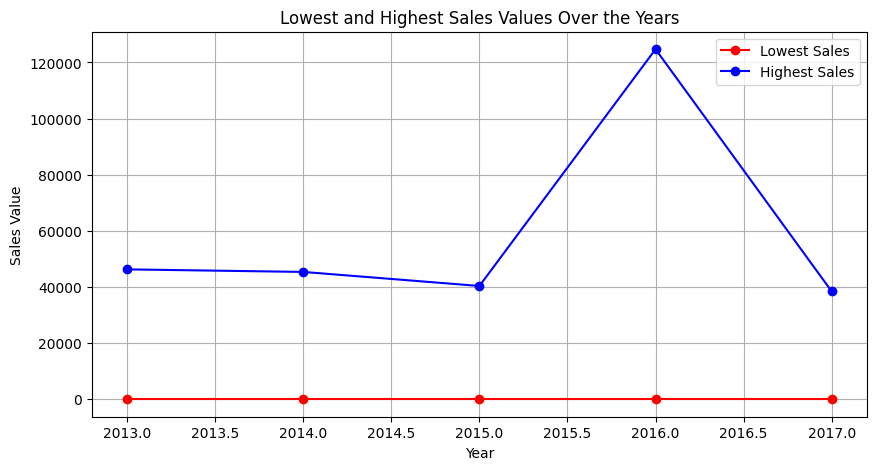

In [114]:
# Create a figure and axis for the line plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the lowest sales values as a line
ax.plot(result_df['Year'], result_df['Lowest Sales Value'], marker='o', linestyle='-', color='red', label='Lowest Sales')

# Plot the highest sales values as a line
ax.plot(result_df['Year'], result_df['Highest Sales Value'], marker='o', linestyle='-', color='blue', label='Highest Sales')

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Sales Value')
ax.set_title('Lowest and Highest Sales Values Over the Years')
ax.legend()

# Show the line plot
plt.grid(True)
plt.show()

3.  Did the earthquake impact sales?

In [115]:
# Group by both year and date
grouped_sales = train_data.groupby(['year', 'date'])['sales'].sum().reset_index()

# Print the result Series
grouped_sales

,year,date,sales
0,2013.0,2013-01-01,2511.618999
1,2013.0,2013-01-02,496092.417944
2,2013.0,2013-01-03,361461.231124
3,2013.0,2013-01-04,354459.677093
4,2013.0,2013-01-05,477350.121229
...,...,...,...
1683,2017.0,2017-08-11,826373.722022
1684,2017.0,2017-08-12,792630.535079
1685,2017.0,2017-08-13,865639.677471
1686,2017.0,2017-08-14,760922.406081


In [116]:
# Define the date range
start_date = pd.to_datetime('2016-04-01')
end_date = pd.to_datetime('2016-04-30')

#grouped_sales.index.get_level_values('date') extracts the date values from the index of the grouped_sales DataFrame.
#This assumes that the date information is present in the index.

#Set the "date" column as the index
grouped_sales.set_index('date', inplace=True)

# Create a Boolean mask to filter for dates within the range
date_mask = (grouped_sales.index.get_level_values('date')>= start_date) & (grouped_sales.index.get_level_values('date') <= end_date)

# Apply the mask to filter the data
sales_in_date_range = grouped_sales[date_mask]

# Display the sales data within the specified date range
print(sales_in_date_range)

              year         sales
date                            
2016-04-01  2016.0  8.724673e+05
2016-04-02  2016.0  1.150825e+06
2016-04-03  2016.0  1.266908e+06
2016-04-04  2016.0  7.952372e+05
2016-04-05  2016.0  7.257501e+05
2016-04-06  2016.0  7.447848e+05
2016-04-07  2016.0  5.879397e+05
2016-04-08  2016.0  6.897272e+05
2016-04-09  2016.0  9.279814e+05
2016-04-10  2016.0  1.008877e+06
2016-04-11  2016.0  6.653490e+05
2016-04-12  2016.0  6.516570e+05
2016-04-13  2016.0  6.726115e+05
2016-04-14  2016.0  5.467852e+05
2016-04-15  2016.0  6.676063e+05
2016-04-16  2016.0  8.621215e+05
2016-04-17  2016.0  1.271834e+06
2016-04-18  2016.0  1.345921e+06
2016-04-19  2016.0  1.152089e+06
2016-04-20  2016.0  1.062426e+06
2016-04-21  2016.0  2.002160e+06
2016-04-22  2016.0  8.570592e+05
2016-04-23  2016.0  1.022143e+06
2016-04-24  2016.0  1.039370e+06
2016-04-25  2016.0  6.800008e+05
2016-04-26  2016.0  7.047994e+05
2016-04-27  2016.0  6.702881e+05
2016-04-28  2016.0  5.433398e+05
2016-04-29

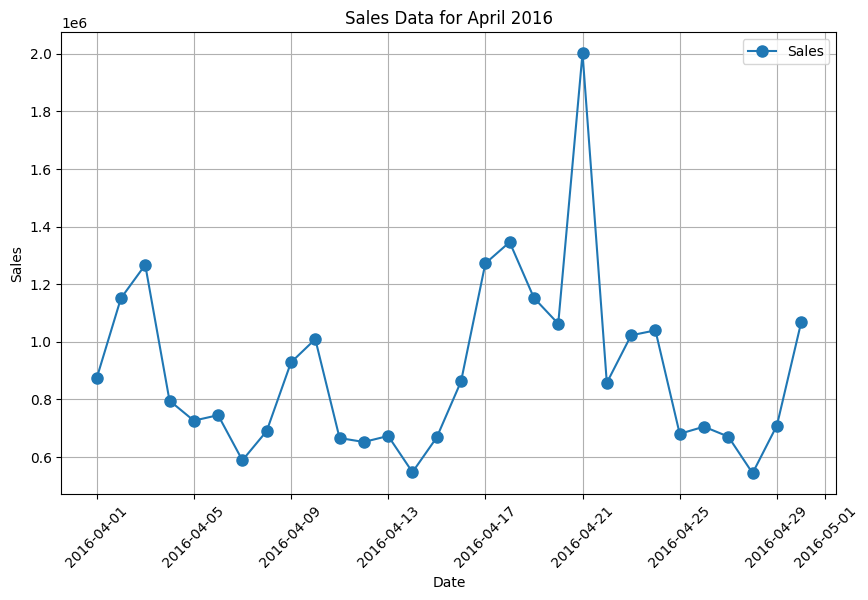

In [128]:
# # Create a line plot using Plotly Express
# fig = px.line(sales_in_date_range, x=sales_in_date_range.index, y='sales', title='Sales Data for April 2016')

# # Customize the appearance
# fig.update_traces(mode='lines+markers', marker=dict(size=8))
# fig.update_xaxes(title_text='Date', tickangle=-45)
# fig.update_yaxes(title_text='Sales')
# fig.update_layout(xaxis=dict(showgrid=True), yaxis=dict(showgrid=True), template='ggplot2')

# # Show the plot
# fig.show();

# Create a line plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(sales_in_date_range.index, sales_in_date_range['sales'], marker='o', markersize=8, linestyle='-', label='Sales')
plt.title('Sales Data for April 2016')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.grid(True)

# Show the legend
plt.legend()

# Display the plot
plt.show()

There was a sharp rise in sales most probably due to panic after the occurenceof the earthquake, followed by a sudden decline in the supermarket sales due to relief suport and donations to the affected  by well wishers.

4.  Are certain groups of stores selling more products? (Cluster, city,
    state, type)

In [129]:
group_of_stores = train_data.groupby(['store_nbr', 'city', 'state'])['sales'].sum().reset_index()

#Top ten stores per city, state and sales
group_of_stores1 = group_of_stores.sort_values(by='sales', ascending=False).head(10)
#Preview of dataframe
group_of_stores1

,store_nbr,city,state,sales
43,44.0,Quito,Pichincha,6.335614e+07
44,45.0,Quito,Pichincha,5.568902e+07
46,47.0,Quito,Pichincha,5.202448e+07
2,3.0,Quito,Pichincha,5.153353e+07
48,49.0,Quito,Pichincha,4.434682e+07
45,46.0,Quito,Pichincha,4.280473e+07
47,48.0,Quito,Pichincha,3.674180e+07
50,51.0,Guayaquil,Guayas,3.360386e+07
7,8.0,Quito,Pichincha,3.112407e+07
49,50.0,Ambato,Tungurahua,2.927375e+07


In [130]:
group_of_stores_sorted = group_of_stores

#group of stores by store number and sales
stores_by_sales = group_of_stores_sorted.groupby('store_nbr')['sales'].sum().reset_index()
#sort dataframe
stores_by_sales_sorted  = stores_by_sales.sort_values(by='sales', ascending=False)

#Preview of sorted stores with most sales(Top Ten)
top_ten_stores_sorted =stores_by_sales_sorted.head(10)

top_ten_stores_sorted 

,store_nbr,sales
43,44.0,6.335614e+07
44,45.0,5.568902e+07
46,47.0,5.202448e+07
2,3.0,5.153353e+07
48,49.0,4.434682e+07
45,46.0,4.280473e+07
47,48.0,3.674180e+07
50,51.0,3.360386e+07
7,8.0,3.112407e+07
49,50.0,2.927375e+07


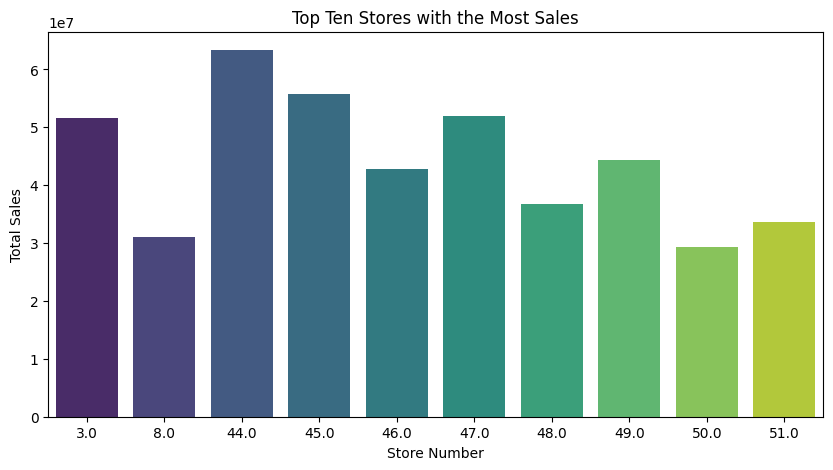

In [131]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Create a bar plot to visualize the top ten stores with most sales
sns.barplot(x='store_nbr', y='sales', data=top_ten_stores_sorted, palette='viridis', ax=ax)

# Set labels and title
ax.set_xlabel('Store Number')
ax.set_ylabel('Total Sales')
ax.set_title('Top Ten Stores with the Most Sales')

# Show the plot
#plt.grid(True)
plt.show()

Store No. 44 had the most sales followed closely by store No.45

In [132]:
group_of_sales_by_state = train_data.groupby('state')['sales'].sum().reset_index()
grouping_sales_by_state_sorted = group_of_sales_by_state.sort_values(by='sales',ascending=False)
top_ten__sales_by_state = grouping_sales_by_state_sorted.head(5)

top_ten__sales_by_state

,state,sales
12,Pichincha,5.975859e+08
6,Guayas,1.686500e+08
0,Azuay,5.019405e+07
15,Tungurahua,4.115977e+07
14,Santo Domingo de los Tsachilas,3.661757e+07


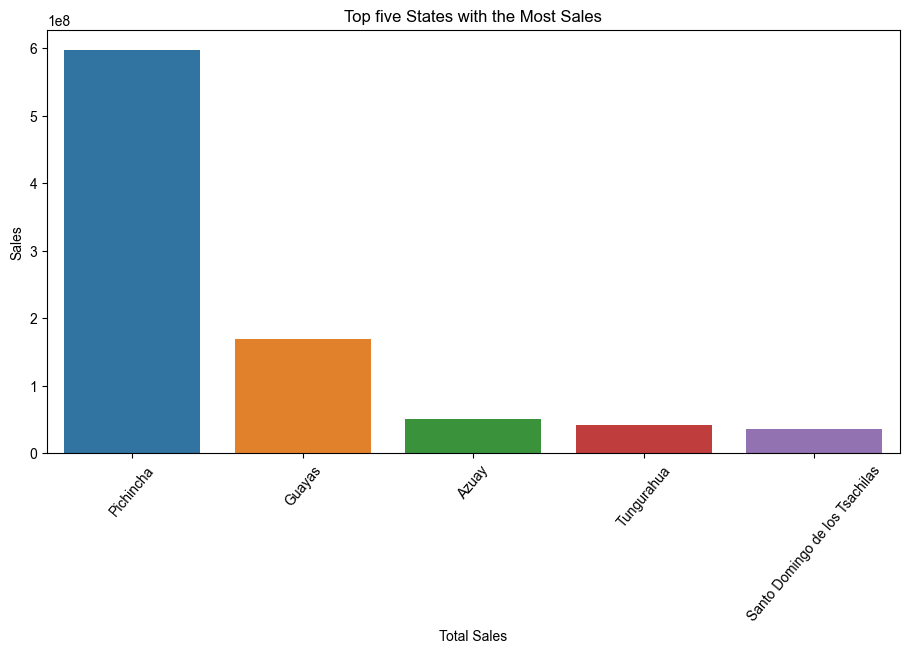

In [133]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(11, 5.5))

# Create a bar plot to visualize the top five stores with most sales
sns.barplot(x='state', y='sales', data=top_ten__sales_by_state, ax=ax)

# Set labels and title
ax.set_xlabel('Total Sales')
ax.set_ylabel('Sales')
ax.set_title('Top five States with the Most Sales')
plt.xticks(rotation=50)
sns.set_style('darkgrid')
sns.set_palette('husl')

# Show the plot
#plt.grid(True)
plt.show()

5.  Are sales affected by promotions, oil prices and holidays?

In [134]:
# Perform one-hot encoding on holiday types
#make a copy of train dataset for visualization
train_dataA = train_data.copy()
#Convert dataframe column to "category"
train_dataA['holiday_types'] = train_dataA['holiday_types'].astype('category')
train_dataA['holiday_types'].dtype

CategoricalDtype(categories=['Additional', 'Bridge', 'Event', 'Holiday', 'Not a Holiday',
                  'Transfer', 'Work Day'],
, ordered=False, categories_dtype=object)

In [135]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the 'holiday_types' column
holiday_encoded = encoder.fit_transform(train_dataA['holiday_types'].values.reshape(-1, 1))

# Get the feature names after one-hot encoding
holiday_feature_names = encoder.get_feature_names_out(['holiday_types'])

# Create a DataFrame with the one-hot encoded values and column names
holiday_encoded_df = pd.DataFrame(holiday_encoded, columns=holiday_feature_names)

# Reset the index of train_dataA and holiday_encoded_df
train_dataA.reset_index(drop=True, inplace=True)
holiday_encoded_df.reset_index(drop=True, inplace=True)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df = pd.concat([train_dataA, holiday_encoded_df], axis=1)

# Drop the original 'holiday_types' column
df.drop(columns=['holiday_types'], inplace=True)

# Check the resulting DataFrame
df.head(3)

,store_nbr,family,sales,onpromotion,Oil_prices,city,state,transferred,year,month,day_of_month,day_of_week,holiday_types_Additional,holiday_types_Bridge,holiday_types_Event,holiday_types_Holiday,holiday_types_Not a Holiday,holiday_types_Transfer,holiday_types_Work Day
0,1.0,AUTOMOTIVE,0.0,0.0,93.139999,Quito,Pichincha,False,2013.0,1.0,1.0,Tuesday,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,42.0,CELEBRATION,0.0,0.0,93.139999,Cuenca,Azuay,False,2013.0,1.0,1.0,Tuesday,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,42.0,BREAD/BAKERY,0.0,0.0,93.139999,Cuenca,Azuay,False,2013.0,1.0,1.0,Tuesday,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [136]:
# Calculate the correlation matrix for numerical columns
correlation_matrix = df[['sales', 'onpromotion', 'Oil_prices', 'holiday_types_Additional', 'holiday_types_Bridge',
                         'holiday_types_Event', 'holiday_types_Holiday', 'holiday_types_Not a Holiday',
                         'holiday_types_Transfer', 'holiday_types_Work Day']].corr()

relevant_features = correlation_matrix['sales'].sort_values(ascending=False)
relevant_features

sales                          1.000000
onpromotion                    0.428241
holiday_types_Additional       0.017489
holiday_types_Event            0.011060
holiday_types_Transfer         0.007134
holiday_types_Bridge           0.003318
holiday_types_Work Day         0.000642
holiday_types_Holiday         -0.000176
holiday_types_Not a Holiday   -0.013965
Oil_prices                    -0.075570
Name: sales, dtype: float64

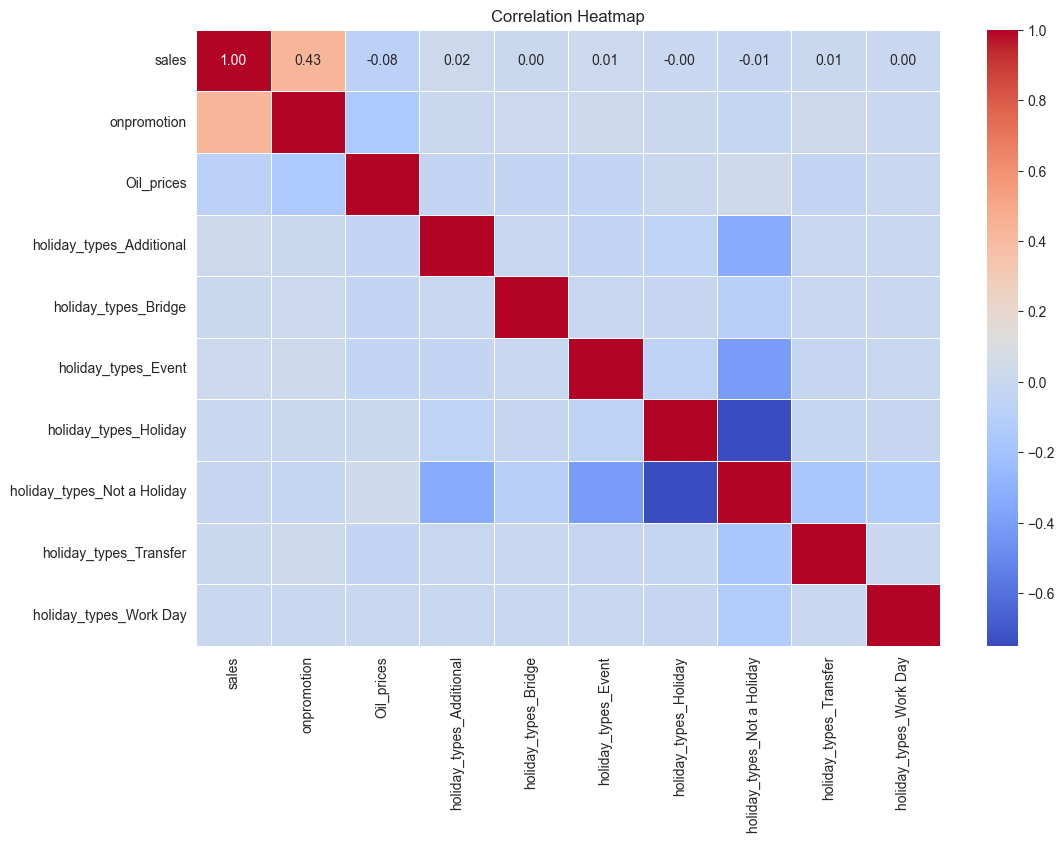

In [137]:
#Heatmap to aid in visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()


The strongest correlation with sales is the "onpromotion" variable, indicating that promotions have a moderate positive effect on sales. There are very weak positive correlation between sales and some some holiday-related categorical variables, such as "holiday_types_Additional" and "holiday_types_Event." Oil prices have a weak negative correlation with sales, suggesting a minor impact(oil prices increase, sales tend to decrease slightly). Most of the holiday-related categorical variables have weak to negligible correlations with sales, indicating that holidays do not have a significant direct impact on sales in this dataset.

  What analysis can we get from the date and its extractable features?

In [138]:
# Group the data by 'year' and 'month' and calculate the mean sales for each group
mean_sales_by_year_month = train_data.groupby(['year', 'month'])['sales'].mean()

# Reset the index to make it a DataFrame
mean_sales_by_year_month = mean_sales_by_year_month.reset_index()

# Print the resulting DataFrame
print(mean_sales_by_year_month)

      year  month       sales
0   2013.0    1.0  186.952405
1   2013.0    2.0  193.581846
2   2013.0    3.0  206.880581
3   2013.0    4.0  205.639071
4   2013.0    5.0  210.184563
5   2013.0    6.0  215.691343
6   2013.0    7.0  203.983455
7   2013.0    8.0  212.479434
8   2013.0    9.0  220.593588
9   2013.0   10.0  213.164266
10  2013.0   11.0  231.136537
11  2013.0   12.0  298.669737
12  2014.0    1.0  342.341709
13  2014.0    2.0  241.268892
14  2014.0    3.0  368.661236
15  2014.0    4.0  240.577087
16  2014.0    5.0  242.203129
17  2014.0    6.0  244.634652
18  2014.0    7.0  350.830102
19  2014.0    8.0  251.351805
20  2014.0    9.0  374.530792
21  2014.0   10.0  369.213666
22  2014.0   11.0  384.056027
23  2014.0   12.0  459.810542
24  2015.0    1.0  269.666595
25  2015.0    2.0  275.420792
26  2015.0    3.0  282.368624
27  2015.0    4.0  279.743138
28  2015.0    5.0  320.958116
29  2015.0    6.0  397.249619
30  2015.0    7.0  403.030170
31  2015.0    8.0  415.692304
32  2015.0

Text(0, 0.5, 'Mean Sales')

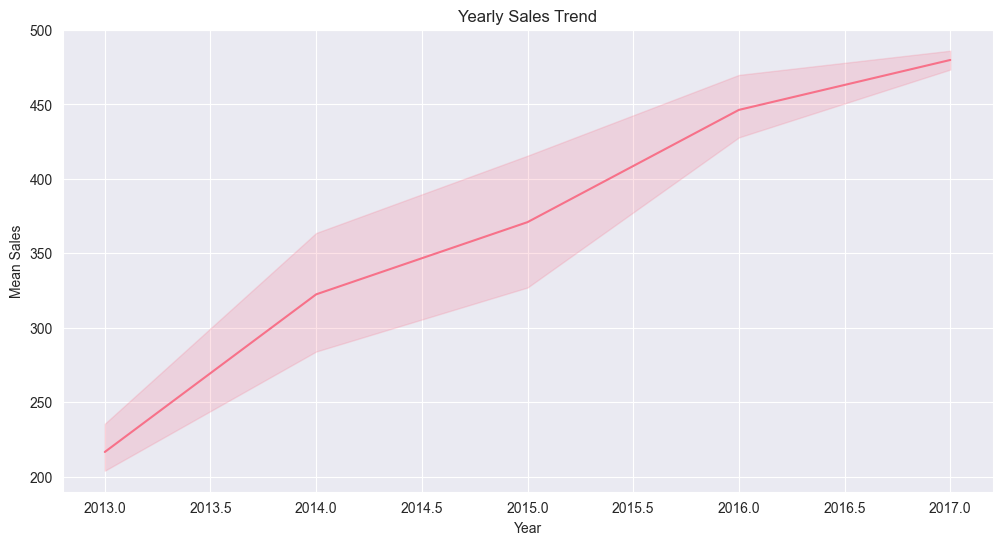

In [139]:
# Create a figure with two subplots, one for yearly sales and one for monthly sales
fig, ax1 = plt.subplots(1, figsize=(12, 6))

# Plot the yearly sales trend
sns.lineplot(data=mean_sales_by_year_month, x='year', y='sales', ax=ax1)
ax1.set_title('Yearly Sales Trend')
ax1.set_xlabel('Year')
ax1.set_ylabel('Mean Sales')

There has been a positive trend of increased sales over all the years.

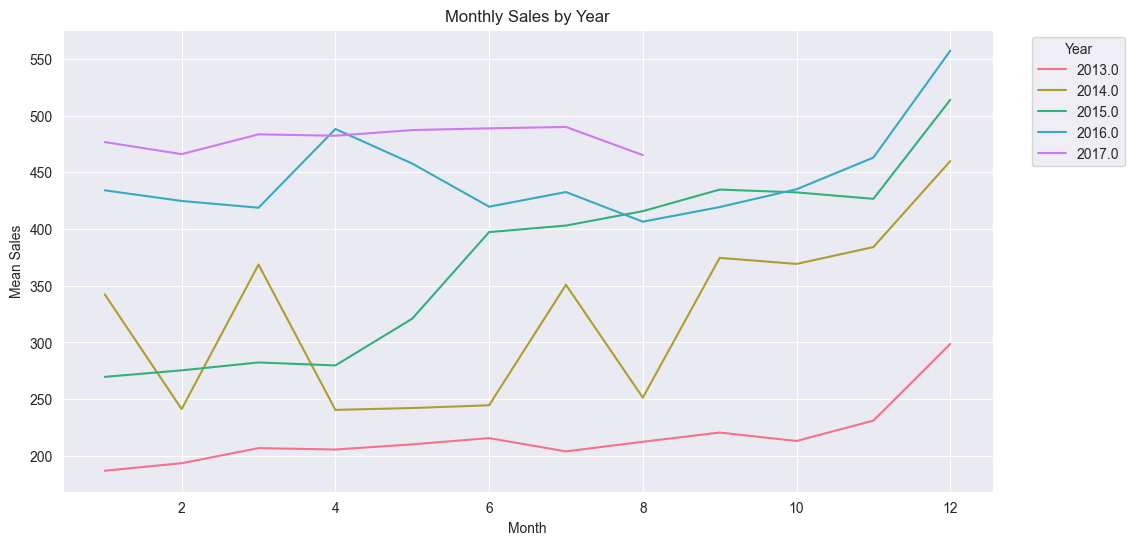

In [140]:
# Define a custom color palette
# we define a custom color palette using Seaborn's "husl" palette

custom_palette = sns.color_palette("husl", n_colors=len(mean_sales_by_year_month['year'].unique()))
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot monthly sales for each year with the custom color palette
sns.lineplot(data=mean_sales_by_year_month, x='month', y='sales', hue='year', ax=ax, palette=custom_palette)

# Set labels and legend
ax.set_xlabel('Month')
ax.set_ylabel('Mean Sales')
ax.set_title('Monthly Sales by Year')

# Show legend
plt.legend(title='Year', loc='upper right', bbox_to_anchor=(1.15, 1))

plt.show()


There's slight seasonality towards end  of the year characterised by increase in sales over all years. This is particularly from August to December of each year.

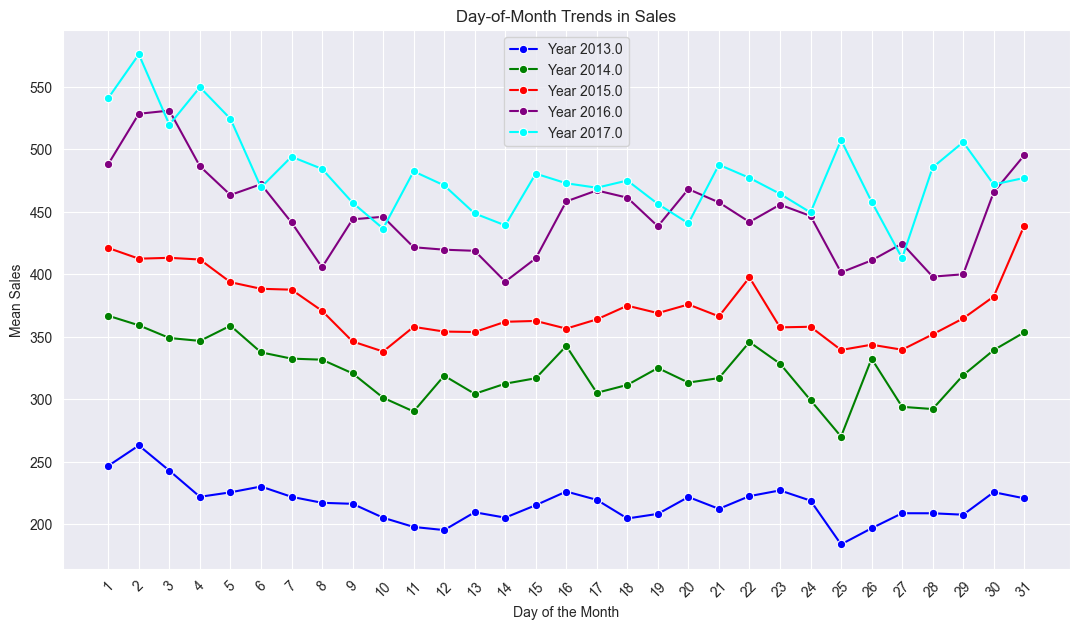

In [141]:
# Create a line plot for each year to visualize day-of-month trends
plt.figure(figsize=(13, 7))

# Define custom colors for each year
custom_colors = {
    2013: 'blue',
    2014: 'green',
    2015: 'red',
    2016: 'purple',
    2017: 'cyan'
}

# Iterate over unique years in your data
for year in train_data['year'].unique():
    year_data = train_data[train_data['year'] == year]
    day_of_month_sales = year_data.groupby('day_of_month')['sales'].mean().reset_index()
    sns.lineplot(data=day_of_month_sales, x='day_of_month', y='sales', marker='o', label=f'Year {year}',  color=custom_colors.get(year, 'black'))

plt.title('Day-of-Month Trends in Sales')
plt.xlabel('Day of the Month')
plt.ylabel('Mean Sales')
plt.xticks(range(1, 32), rotation=45)
plt.grid(True)
plt.legend()
plt.show();

There are high sales at the beginning and end of each month. The first four days at start of each month have high sales and the last five days of the month have also high sales. There's a slight increase in sales at the middle of the month, probably due to purchases from employees that receive mid-month salaries.

Hypothesis testing

Testing Null hypothesis

Null Hypothesis (H0): There is no significant difference in sales between products on promotion and products not on promotion.

In [142]:
# Separate data into two groups
on_promotion = train_data[train_data['onpromotion'] == 1]['sales']
not_on_promotion = train_data[train_data['onpromotion'] == 0]['sales']

# Perform an independent samples t-test
t_statistic, p_value = stats.ttest_ind(on_promotion, not_on_promotion, equal_var=False)

# Set your significance level (alpha)
alpha = 0.05

# Compare p-value to alpha
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in sales.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in sales.")

Reject the null hypothesis: There is a significant difference in sales.


 promotions have a statistically significant impact on sales.

#### Check for Stationarity

There is an increasing trend of sales over the years

There is also seasonality in the sales, towards the end of each year there is a characteristic increase in sales.

KPSS TEST

The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test is a statistical test used to check for the stationarity of a time series data set. Unlike tests such as the Augmented Dickey-Fuller (ADF) test, which test for unit roots (i.e., non-stationarity), the KPSS test focuses on determining whether a time series is stationary around a deterministic trend. It was developed as an alternative to the ADF test and is particularly useful when dealing with economic and financial time series data.

Null Hypothesis (H0): The null hypothesis of the KPSS test assumes that the data is stationary around a deterministic trend. In other words, it assumes that the data has a trend component but is otherwise stationary. Mathematically, the null hypothesis can be expressed as:
H0: The data is stationary around a trend.
Null hpothesis: Series is stationary

Alternative Hypothesis (H1): The alternative hypothesis of the KPSS test suggests that the data is not stationary around a deterministic trend. This implies that the data is either non-stationary or stationary around a stochastic (random) trend.
H1: The data is not stationary around a trend.
Alternate hypothesis: Series is not stationary

Test Statistic: The KPSS test calculates a test statistic, which is used to determine whether to accept or reject the null hypothesis. The test statistic is typically denoted as KPSS. It is based on the variance of the data series under the null hypothesis.

Interpretation of the Test Statistic: The KPSS test statistic is compared to critical values at various significance levels (e.g., 1%, 5%, or 10%). If the test statistic is less than the critical value, you fail to reject the null hypothesis, indicating that the data is stationary around a deterministic trend. If the test statistic exceeds the critical value, you reject the null hypothesis, suggesting that the data is not stationary around a trend.

In [143]:
#In the KPSS test, the null hypothesis is that the time series is stationary, while the alternative hypothesis is that it is not stationary.

from statsmodels.tsa.stattools import kpss

stats, p, lags, critical_values = kpss(train_data['sales'], 'ct')

print(f'Test statistics:{stats}')

print(f'P-value:{p}')

print(f'Critical Values:{critical_values}')

if p<0.05:
    print('Series is not stationary')
else:
    print('Series is stationary')

Test statistics:1.6299871420705534
P-value:0.01
Critical Values:{'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not stationary


Visualization of sales

In [144]:
#Resampling
#specify data column to include
df_column = ['sales']

# Downsample the 'sales' column to Monthly frequency
df_monthly_mean = train_data[df_column].resample('M').sum()
df_monthly_mean.head()

,sales
date,
2013-01-31,1.032762e+07
2013-02-28,9.658960e+06
2013-03-31,1.142850e+07
2013-04-30,1.099346e+07
2013-05-31,1.198556e+07


In [145]:
# Downsample the 'sales' column to Weekly frequency
df_weekly_mean = train_data[df_column].resample('W').sum()
df_weekly_mean.head()

,sales
date,
2013-01-06,2.211570e+06
2013-01-13,2.373618e+06
2013-01-20,2.368007e+06
2013-01-27,2.272165e+06
2013-02-03,2.476891e+06


<Axes: xlabel='date', ylabel='sales'>

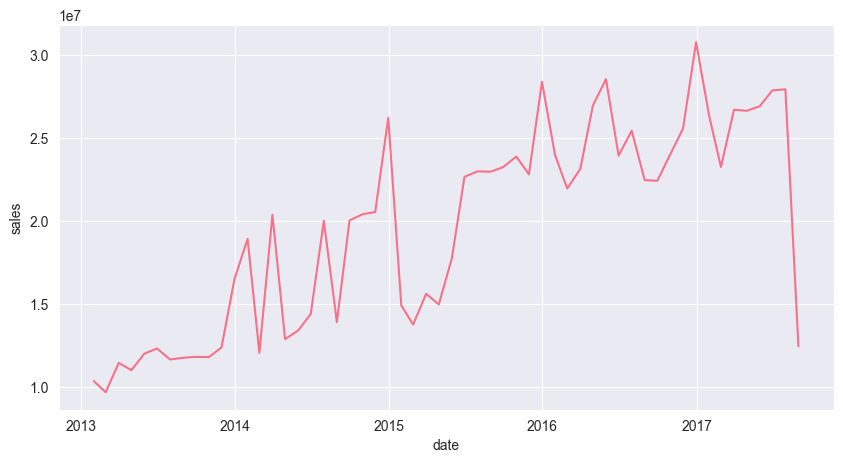

In [146]:
plt.figure(figsize=(10,5))
sns.lineplot(x=df_monthly_mean.index, y=df_monthly_mean['sales'])

<Axes: xlabel='date', ylabel='sales'>

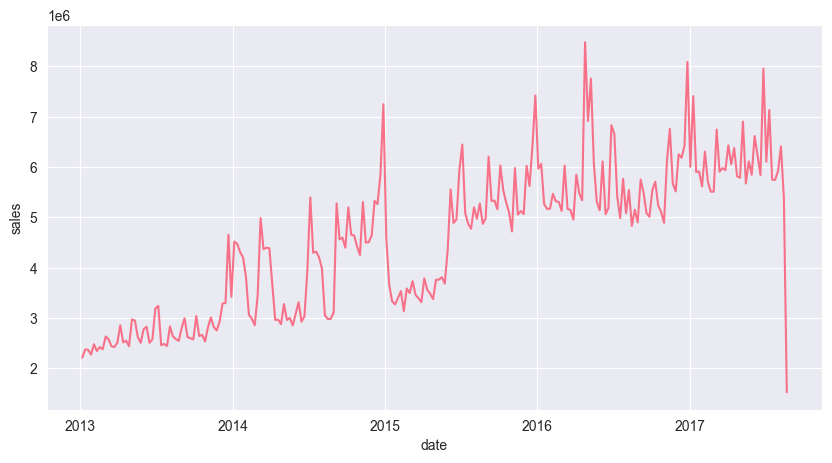

In [147]:
plt.figure(figsize=(10,5))
sns.lineplot(x=df_weekly_mean.index, y=df_weekly_mean['sales'])

Subsampling

Due to computational difficulty, I decided to use 10% of my train data for modelling purpose

I subsampled the data randomly

In [148]:
#sort train data
train_data.sort_index()

train_data_final = train_data.sample(frac=0.2, random_state=42)

#train_data_final = train_data

In [149]:
train_data_final = train_data_final.sort_index()

In [150]:
train_data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 610870 entries, 2013-01-01 to 2017-08-15
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   store_nbr      610870 non-null  float64
 1   family         610870 non-null  object 
 2   sales          610870 non-null  float64
 3   onpromotion    610870 non-null  float64
 4   Oil_prices     610870 non-null  float64
 5   city           610870 non-null  object 
 6   state          610870 non-null  object 
 7   holiday_types  610870 non-null  object 
 8   transferred    610870 non-null  bool   
 9   year           610870 non-null  float64
 10  month          610870 non-null  float64
 11  day_of_month   610870 non-null  float64
 12  day_of_week    610870 non-null  object 
dtypes: bool(1), float64(7), object(5)
memory usage: 61.2+ MB


Making Series Stationary

Differencing:
Differencing involves computing the difference between consecutive observations in a time series. The idea is to remove the underlying trends or patterns that cause the time series to be non-stationary. The result is a new time series called the "differenced" or "first difference" series.

How Differencing Attains Stationarity:

Trend Removal: Differencing eliminates the effect of a constant or linear trend. When a time series exhibits a consistent upward or downward movement over time, the differences tend to fluctuate around a constant mean, making the data stationary.

Seasonality Removal: Differencing can also help remove seasonality. If a time series exhibits seasonal patterns, taking differences at the seasonal lag (e.g., one year for annual seasonality) can often remove the seasonal component, leaving behind stationary data.

Stabilizing Variance: Differencing can reduce the variance of the time series. Non-stationary data often has changing variance, which can lead to difficulties in modeling and forecasting. Differencing can help stabilize the variance, making it constant over time.

Removing Serial Correlation: Differencing can reduce or eliminate autocorrelation (correlation between lagged values). Autocorrelation is a common characteristic of non-stationary data. By differencing, you can often remove this correlation and make the data stationary.

In [151]:
train_data_final['sales_diff'] = train_data_final['sales'] - train_data_final['sales'].shift(1)

#Subtracted minimum value and added 1 to ensure minimum value in the sales column is 1
#This is useful as we are working with certain models that require positive input values.
#This approach does not change the relative difference between values.

train_data_final['sales_diff'] = train_data_final['sales_diff'] - train_data_final['sales_diff'].min() + 1

In [152]:
train_data_final.dropna(inplace=True)
train_data_final.isna().sum()

store_nbr        0
family           0
sales            0
onpromotion      0
Oil_prices       0
city             0
state            0
holiday_types    0
transferred      0
year             0
month            0
day_of_month     0
day_of_week      0
sales_diff       0
dtype: int64

In [153]:
from statsmodels.tsa.stattools import kpss

stats, p, lags, critical_values = kpss(train_data_final['sales_diff'], 'ct')

print(f'Test statistics:{stats}')

print(f'P-value:{p}')

print(f'Critical Values:{critical_values}')

if p<0.05:
    print('Series is not stationary')
else:
    print('Series is stationary')

Test statistics:0.012638326952224627
P-value:0.1
Critical Values:{'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is stationary


Text(0.5, 1.0, 'Detrended sales values')

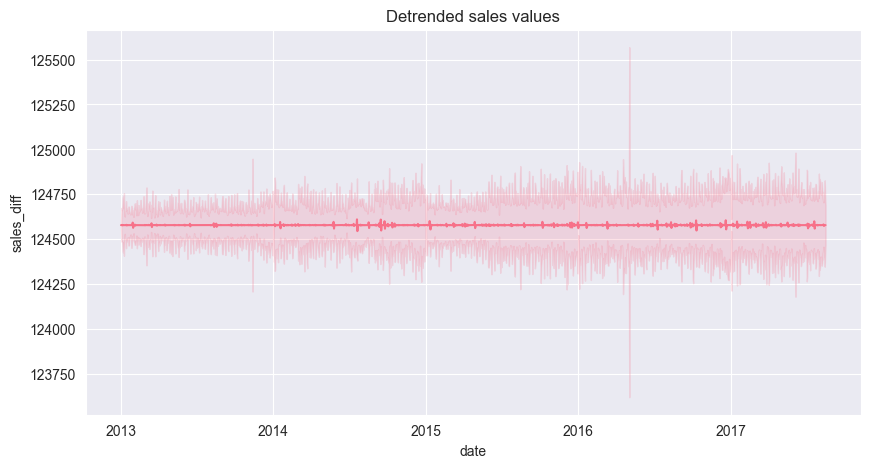

In [154]:
#Visualize the detrended sales 

plt.figure(figsize=(10,5))
sns.lineplot(x=train_data_final.index, y=train_data_final['sales_diff'])
plt.title('Detrended sales values')

In [155]:
train_data_final.to_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\STREAMLIT_PROJECT\Dataset\final_clean_train.csv')


Preprocessing

In [2]:
#Loading of clean train data
final_train = pd.read_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\STREAMLIT_PROJECT\Dataset\final_clean_train.csv', parse_dates=['date'], index_col=0)

#final_train['date'] = final_train.index

final_train.head(3)

,store_nbr,family,sales,onpromotion,Oil_prices,city,state,holiday_types,transferred,year,month,day_of_month,day_of_week,sales_diff
date,,,,,,,,,,,,,,
2013-01-01,52.0,CLEANING,0.0,0.0,93.139999,Manta,Manabi,Holiday,False,2013.0,1.0,1.0,Tuesday,124578.845
2013-01-01,34.0,BREAD/BAKERY,0.0,0.0,93.139999,Guayaquil,Guayas,Holiday,False,2013.0,1.0,1.0,Tuesday,124578.845
2013-01-01,18.0,SCHOOL AND OFFICE SUPPLIES,0.0,0.0,93.139999,Quito,Pichincha,Holiday,False,2013.0,1.0,1.0,Tuesday,124578.845


In [3]:
final_test = pd.read_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\STREAMLIT_PROJECT\Dataset\test_dataset.csv', parse_dates=['date'], index_col=0)

#final_test['date'] = final_test.index

final_test.head(3)

,store_nbr,family,onpromotion,Oil_prices,city,state,holiday_types,transferred,year,month,day_of_month,day_of_week
date,,,,,,,,,,,,
2017-08-16,1,AUTOMOTIVE,0,46.799999,Quito,Pichincha,Not a Holiday,False,2017,8,16,Wednesday
2017-08-16,1,BABY CARE,0,46.799999,Quito,Pichincha,Not a Holiday,False,2017,8,16,Wednesday
2017-08-16,1,BEAUTY,2,46.799999,Quito,Pichincha,Not a Holiday,False,2017,8,16,Wednesday


In [4]:
#dropping of 'sales' column not detrended
final_train.drop(columns='sales', axis=1, inplace=True)
#Renaming differenced sales values, 'sales_diff' to 'sales'
final_train.rename(columns={'sales_diff': 'sales'}, inplace=True)

decide to drop unnecessary columns in train data and evaluation data set that had low information value to the target

I had added columns like, "holiday_types", 	month"	"transferred"	"day_of_week" for visualization analysis


In [5]:
final_train.drop(columns=['transferred', 'day_of_month', 'holiday_types'], inplace=True)

final_test.drop(columns=['transferred', 'day_of_month', 'holiday_types'], inplace=True)

In [6]:
final_train.columns

Index(['store_nbr', 'family', 'onpromotion', 'Oil_prices', 'city', 'state',
       'year', 'month', 'day_of_week', 'sales'],
      dtype='object')

In [7]:
#A look of information summary
final_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 610869 entries, 2013-01-01 to 2017-08-15
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   store_nbr    610869 non-null  float64
 1   family       610869 non-null  object 
 2   onpromotion  610869 non-null  float64
 3   Oil_prices   610869 non-null  float64
 4   city         610869 non-null  object 
 5   state        610869 non-null  object 
 6   year         610869 non-null  float64
 7   month        610869 non-null  float64
 8   day_of_week  610869 non-null  object 
 9   sales        610869 non-null  float64
dtypes: float64(6), object(4)
memory usage: 51.3+ MB


In [8]:
#Renamed 'family' column to 'product'
final_train.rename(columns={'family': 'Product'}, inplace=True)

final_train.rename(columns={'family': 'Product'}, inplace=True)

final_test.rename(columns={'family': 'Product'}, inplace=True)

In [11]:
final_train['store_nbr'] = final_train['store_nbr'].astype('int32')
final_train['onpromotion'] = final_train['onpromotion'].astype('float32')
final_train['Oil_prices'] = final_train['Oil_prices'].astype('float32')
final_train['year'] = final_train['year'].astype('float32')
final_train['month'] = final_train['month'].astype('float32')
final_train['sales'] = final_train['sales'].astype('float32')

Data Splitting

In [12]:
#shape of train data
final_train.shape

(610869, 10)

In [13]:

#split_point between train and eval sets
train_size = int(len(final_train) * 0.7)

#Select the first 70% of rows as training data
train_dataset =  final_train.iloc[:train_size]

#Remaining row will be evaluation set

eval_dataset = final_train.iloc[train_size:]

In [14]:
#Remove the target from training & evaluation sets
train_features = train_dataset.drop('sales', axis=1)

eval_features = eval_dataset.drop('sales', axis=1)

In [16]:
#Shape of target for evaluation
print(train_dataset.shape, eval_dataset.shape, train_features.shape, eval_features.shape)


(427608, 10) (183261, 10) (427608, 9) (183261, 9)


Creation of transformers for both numerical and categorical features

In [103]:
# Feature encoding
# List of all features 
all_features =['store_nbr','onpromotion', 'Product', 'onpromotion', 'Oil_prices', 
               'city', 'state', 'year', 'month', 'day_of_week',]

 #Define preprocessing steps for numerical and categorical columns

numerical_features = ['store_nbr', 'onpromotion' 'Oil_prices', 'year', 'month']

categorical_features = ['Product', 'city', 'state', 'day_of_week']


numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
]) 

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],#Decided not to encode numerical features
    remainder='passthrough'      # This retains all columns not specified in transformers
)


In [76]:
train_features.head()

,store_nbr,Product,onpromotion,Oil_prices,city,state,year,month,day_of_week
date,,,,,,,,,
2013-01-01,52,CLEANING,0.0,93.139999,Manta,Manabi,2013.0,1.0,Tuesday
2013-01-01,34,BREAD/BAKERY,0.0,93.139999,Guayaquil,Guayas,2013.0,1.0,Tuesday
2013-01-01,18,SCHOOL AND OFFICE SUPPLIES,0.0,93.139999,Quito,Pichincha,2013.0,1.0,Tuesday
2013-01-01,3,HOME AND KITCHEN II,0.0,93.139999,Quito,Pichincha,2013.0,1.0,Tuesday
2013-01-01,9,MAGAZINES,0.0,93.139999,Quito,Pichincha,2013.0,1.0,Tuesday


In [84]:
train_encoded = preprocessor.fit_transform(train_features)
train_encoded

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.31399994e+01, 2.01300000e+03, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.31399994e+01, 2.01300000e+03, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.31399994e+01, 2.01300000e+03, 1.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.46533318e+01, 2.01600000e+03, 4.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.46533318e+01, 2.01600000e+03, 4.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.46533318e+01, 2.01600000e+03, 4.00000000e+00]])

In [85]:
train_encoded.shape

(427608, 83)

In [82]:
train_features

,store_nbr,Product,onpromotion,Oil_prices,city,state,year,month,day_of_week
date,,,,,,,,,
2013-01-01,52,CLEANING,0.0,93.139999,Manta,Manabi,2013.0,1.0,Tuesday
2013-01-01,34,BREAD/BAKERY,0.0,93.139999,Guayaquil,Guayas,2013.0,1.0,Tuesday
2013-01-01,18,SCHOOL AND OFFICE SUPPLIES,0.0,93.139999,Quito,Pichincha,2013.0,1.0,Tuesday
2013-01-01,3,HOME AND KITCHEN II,0.0,93.139999,Quito,Pichincha,2013.0,1.0,Tuesday
2013-01-01,9,MAGAZINES,0.0,93.139999,Quito,Pichincha,2013.0,1.0,Tuesday
...,...,...,...,...,...,...,...,...,...
2016-04-03,52,BEVERAGES,0.0,34.653332,Manta,Manabi,2016.0,4.0,Sunday
2016-04-03,3,HOME APPLIANCES,0.0,34.653332,Quito,Pichincha,2016.0,4.0,Sunday
2016-04-03,18,HOME CARE,0.0,34.653332,Quito,Pichincha,2016.0,4.0,Sunday


In [88]:
# Assuming your_data is your input DataFrame with 'date' as the index
transformed_data = preprocessor.fit_transform(train_features)

# Create a DataFrame for the transformed data
transformed_df = pd.DataFrame(transformed_data)
transformed_df.head()

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,52.0,0.0,93.139999,2013.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,34.0,0.0,93.139999,2013.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,18.0,0.0,93.139999,2013.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,3.0,0.0,93.139999,2013.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,9.0,0.0,93.139999,2013.0,1.0


In [104]:
# Assuming your_data is your input DataFrame with 'date' as the index
transformed_data = preprocessor.fit_transform(train_features)

# Create a DataFrame for the transformed data
transformed_df = pd.DataFrame(transformed_data)

# Set the 'date' column as the index
transformed_df.index = train_features.index

'store_nbr', 'family', 'onpromotion', 'Oil_prices', 'city', 'state', 
'year', 'month', 'day_of_week', 'sales'

# Define the column names
numerical_features = ['store_nbr', 'onpromotion', 'Oil_prices', 'year', 'month', ]
categorical_features = ['Product', 'city', 'state', 'day_of_week']

# Add the column names to the DataFrame if available
if hasattr(preprocessor.named_transformers_['cat']['onehot'], 'get_feature_names_out'):
    # Get the one-hot encoded column names
    cat_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
    # Combine the categorical and numerical column names

    all_columns = list(cat_columns) + numerical_features 
    transformed_df.columns = all_columns


In [105]:
transformed_df.head()

,Product_AUTOMOTIVE,Product_BABY CARE,Product_BEAUTY,Product_BEVERAGES,Product_BOOKS,Product_BREAD/BAKERY,Product_CELEBRATION,Product_CLEANING,Product_DAIRY,Product_DELI,...,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,store_nbr,onpromotion,Oil_prices,year,month
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,52.0,0.0,93.139999,2013.0,1.0
2013-01-01,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,34.0,0.0,93.139999,2013.0,1.0
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,18.0,0.0,93.139999,2013.0,1.0
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,3.0,0.0,93.139999,2013.0,1.0
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,9.0,0.0,93.139999,2013.0,1.0


In [74]:
transformed_df.head()

,date,store_nbr,onpromotionOil_prices,year,month,Product_AUTOMOTIVE,Product_BABY CARE,Product_BEAUTY,Product_BEVERAGES,Product_BOOKS,...,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,52.0,0.0,93.139999,2013.0,1.0
2013-01-01,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,34.0,0.0,93.139999,2013.0,1.0
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,18.0,0.0,93.139999,2013.0,1.0
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,3.0,0.0,93.139999,2013.0,1.0
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,9.0,0.0,93.139999,2013.0,1.0


In [51]:
# Generate the column names for numerical features (as-is)
#numerical_column_names = numerical_features

# Get the one-hot encoder from the categorical transformer
onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']

# Get the feature names from the fitted encoder
categorical_column_names = onehot_encoder.get_feature_names_out(input_features=categorical_features)

# Include the names of the columns that were passed through without transformation
#all_column_names = np.concatenate((numerical_column_names, categorical_column_names))
all_column_names = categorical_column_names
# Add 'year', 'month', 'day_of_month', and 'sales' to the column names
all_column_names = np.concatenate(
    (all_column_names, ['store_nbr', 'onpromotion', 'Oil_prices', 'year', 'month',]))

# Create DataFrames with column names
train_test = pd.DataFrame(train_encoded, columns=all_column_names)

In [52]:
train_test.head()

,Product_AUTOMOTIVE,Product_BABY CARE,Product_BEAUTY,Product_BEVERAGES,Product_BOOKS,Product_BREAD/BAKERY,Product_CELEBRATION,Product_CLEANING,Product_DAIRY,Product_DELI,...,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,store_nbr,onpromotion,Oil_prices,year,month
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,52.0,0.0,93.139999,2013.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,34.0,0.0,93.139999,2013.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,18.0,0.0,93.139999,2013.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,3.0,0.0,93.139999,2013.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,9.0,0.0,93.139999,2013.0,1.0


In [168]:
#convert the 'date' index to a regular column

train_dataset.reset_index(inplace=True)

eval_dataset.reset_index(inplace=True)

final_test.reset_index(inplace=True)

In [169]:
print(eval_dataset.shape, final_test.shape,  train_dataset.shape)

(183261, 11) (28512, 10) (427608, 11)


In [170]:
train_dataset.head()

,date,store_nbr,Product,onpromotion,Oil_prices,city,state,year,month,day_of_month,sales
0,2013-01-01,52,CLEANING,0.0,93.139999,Manta,Manabi,2013.0,1.0,1.0,124578.84375
1,2013-01-01,34,BREAD/BAKERY,0.0,93.139999,Guayaquil,Guayas,2013.0,1.0,1.0,124578.84375
2,2013-01-01,18,SCHOOL AND OFFICE SUPPLIES,0.0,93.139999,Quito,Pichincha,2013.0,1.0,1.0,124578.84375
3,2013-01-01,3,HOME AND KITCHEN II,0.0,93.139999,Quito,Pichincha,2013.0,1.0,1.0,124578.84375
4,2013-01-01,9,MAGAZINES,0.0,93.139999,Quito,Pichincha,2013.0,1.0,1.0,124578.84375


In [171]:
#separate 'dates from training, evaluation and test datasets
#This is to avoid challenges with preprocessing dates

date_column_train = 'date'

date_column_eval = 'date'

date_column_test = 'date'

In [172]:
# fit and transform the features of training data
train_encoded = preprocessor.fit_transform(train_dataset.drop(columns=date_column_train))
#Only tranform without fitting the features of evaluation data_set and test data_set
eval_test_encoded = preprocessor.transform(eval_dataset.drop(columns=date_column_eval))

# Create a placeholder column 'sales' with zeros in the final_test DataFrame
#This is to satisfy the requirements of the preprocessor that expects the "sales" column in the test dataset
## Drop the 'sales' column from final_test_encoded during modelling

final_test['sales'] = 0 
final_test_encoded = preprocessor.transform(final_test.drop(columns=date_column_test))

In [173]:
train_encoded.shape

(427608, 78)

Conversion of Sparse matrix back to data frame

In [174]:
# Convert sparse matrices to dense arrays
train_encoded_dense = train_encoded.toarray()
eval_test_encoded_dense = eval_test_encoded.toarray()
final_test_encoded_dense = final_test_encoded.toarray()

# Generate the column names for numerical features (as-is)
#numerical_column_names = numerical_features

# Get the one-hot encoder from the categorical transformer
onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']

# Get the feature names from the fitted encoder
categorical_column_names = onehot_encoder.get_feature_names_out(input_features=categorical_features)

# Include the names of the columns that were passed through without transformation
#all_column_names = np.concatenate((numerical_column_names, categorical_column_names))
all_column_names = categorical_column_names
# Add 'year', 'month', 'day_of_month', and 'sales' to the column names
all_column_names = np.concatenate(
    (all_column_names, ['store_nbr', 'onpromotion', 'Oil_prices', 'year', 'month', 'day_of_month', 'sales']))

# Create DataFrames with column names
train_test = pd.DataFrame(train_encoded_dense, columns=all_column_names)
eval_test = pd.DataFrame(eval_test_encoded_dense, columns=all_column_names)
final_test1 = pd.DataFrame(final_test_encoded_dense, columns=all_column_names)

In [175]:
train_test.head()

,Product_AUTOMOTIVE,Product_BABY CARE,Product_BEAUTY,Product_BEVERAGES,Product_BOOKS,Product_BREAD/BAKERY,Product_CELEBRATION,Product_CLEANING,Product_DAIRY,Product_DELI,...,city_Riobamba,city_Salinas,city_Santo Domingo,store_nbr,onpromotion,Oil_prices,year,month,day_of_month,sales
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,52.0,0.0,93.139999,2013.0,1.0,1.0,124578.84375
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,34.0,0.0,93.139999,2013.0,1.0,1.0,124578.84375
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,18.0,0.0,93.139999,2013.0,1.0,1.0,124578.84375
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,93.139999,2013.0,1.0,1.0,124578.84375
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.0,0.0,93.139999,2013.0,1.0,1.0,124578.84375


In [176]:
# Add 'date' columns to DataFrames
train_test['date'] = train_dataset[date_column_train].values
eval_test['date'] = eval_dataset[date_column_eval].values
final_test1['date'] = final_test[date_column_test].values

# Set 'date' as the index
train_test.set_index('date', inplace=True)
eval_test.set_index('date', inplace=True)
final_test1.set_index('date', inplace=True)

In [177]:
print(train_test.shape, eval_test.shape, final_test1.shape)

(427608, 78) (183261, 78) (28512, 78)


Modelling

Autocorrelation Test


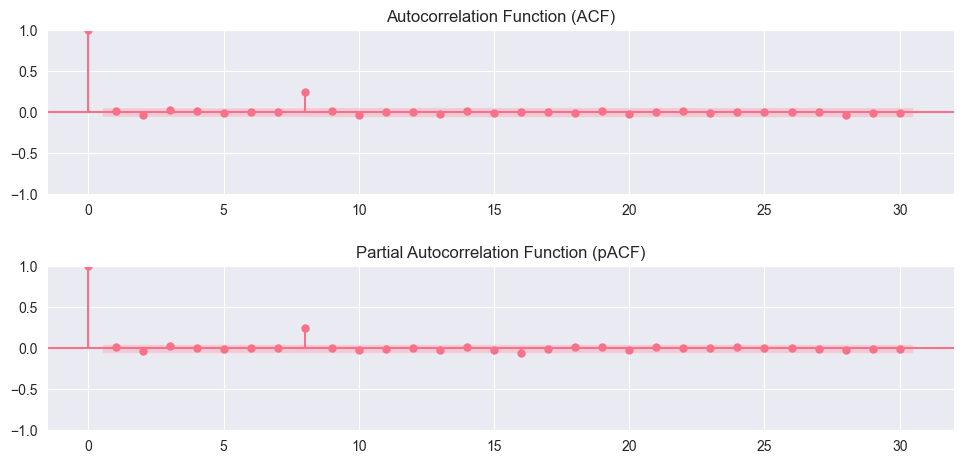

In [178]:
#from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

ts = train_test.groupby(train_test.index)['sales'].sum()

#create subplots with two rows and 1 column, specifying figsize

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))

#plot the Autocorerelation function (ACF) on the first subplot (ax1)
plot_acf(ts, lags=30, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

#plot the Autocorerelation function (PACF) on the first subplot (ax2)
plot_pacf(ts, lags=30, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (pACF)')

#Add a pading between the two subplots for better visualization
plt.tight_layout(pad=2.0)

#Display the plots
plt.show()

Statistical Models

In [179]:
# group the data by date and average sales for stat models
train = train_test.groupby(train_test.index)['sales'].sum().reset_index()
eval = eval_test.groupby(eval_test.index)['sales'].sum().reset_index()

In [180]:
# setting first name as index column
train.set_index('date', inplace=True)
eval.set_index('date', inplace=True)

In [181]:
train.head()

,sales
date,
2013-01-01,4.684165e+07
2013-01-02,4.185857e+07
2013-01-03,4.260588e+07
2013-01-04,4.210807e+07
2013-01-05,4.472338e+07


AR models

In [182]:
#from statsmodels.tsa.ar_model import AutoReg

# Fit the AutoReg model with 1 lag terms
model = AutoReg(train, lags=1).fit()

In [183]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1186
Model:                     AutoReg(1)   Log Likelihood              -20343.017
Method:               Conditional MLE   S.D. of innovations        6907818.230
Date:                Sun, 24 Sep 2023   AIC                          40692.034
Time:                        23:09:45   BIC                          40707.266
Sample:                             1   HQIC                         40697.775
                                 1186                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.43e+07   1.33e+06     33.421      0.000    4.17e+07    4.69e+07
sales.L1       0.0137      0.029      0.468      0.640      -0.044       0.071
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           73.2594           +0.0000j           73.2594            0.0000
-----------------------------------------------------------------------------
"""

In [184]:
# make predictions on eval data
AR_pred = model.predict(start=len(train),
                      end=len(train)+len(eval)-1,
                      dynamic = False
                      )

In [185]:
# evaluate our models
mse= mean_squared_error(eval, AR_pred)
msle=mean_squared_log_error(eval, AR_pred)
rmse= np.sqrt(mean_squared_error(eval, AR_pred)).round(2)
rmsle= np.sqrt(mean_squared_log_error(eval, AR_pred)).round(2)

results=pd.DataFrame([['AR',mse, msle, rmse, rmsle]], columns= ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results

,Model,MSE,MSLE,RMSE,RMSLE
0,AR,8.239443e+13,0.019181,9077137.82,0.14


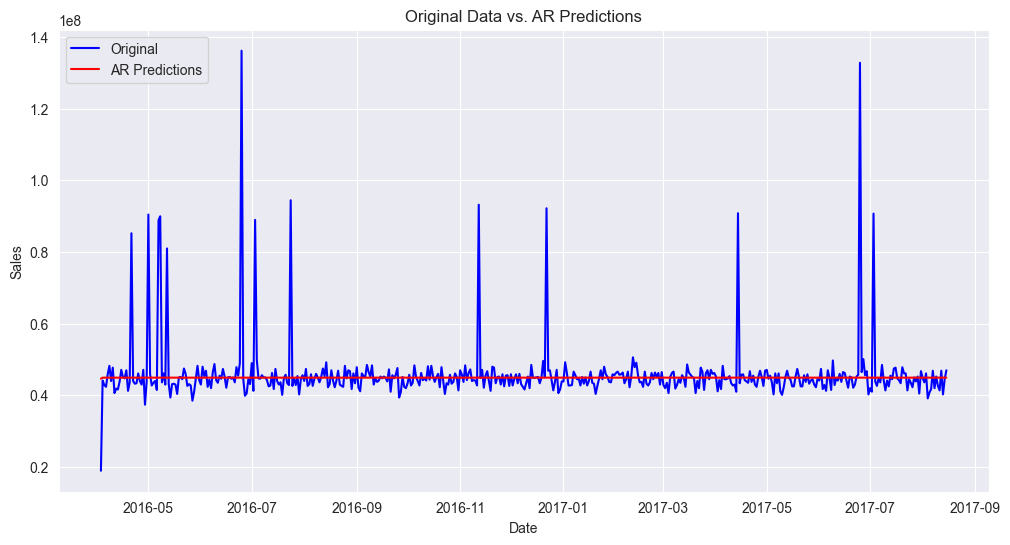

In [186]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the original data
plt.plot(eval.index, eval.values, label='Original', color='blue')

# Plot the AR predictions
plt.plot(eval.index, AR_pred, label='AR Predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Original Data vs. AR Predictions')
plt.legend()
plt.grid(True)

plt.show()

The RMSLE value of 0.14 means that, on average, the model's predictions have a relatively low logarithmic error compared to the actual values. It suggests that the model is making predictions that are reasonably close to the true values, with a relatively small amount of error as shown in the visualization

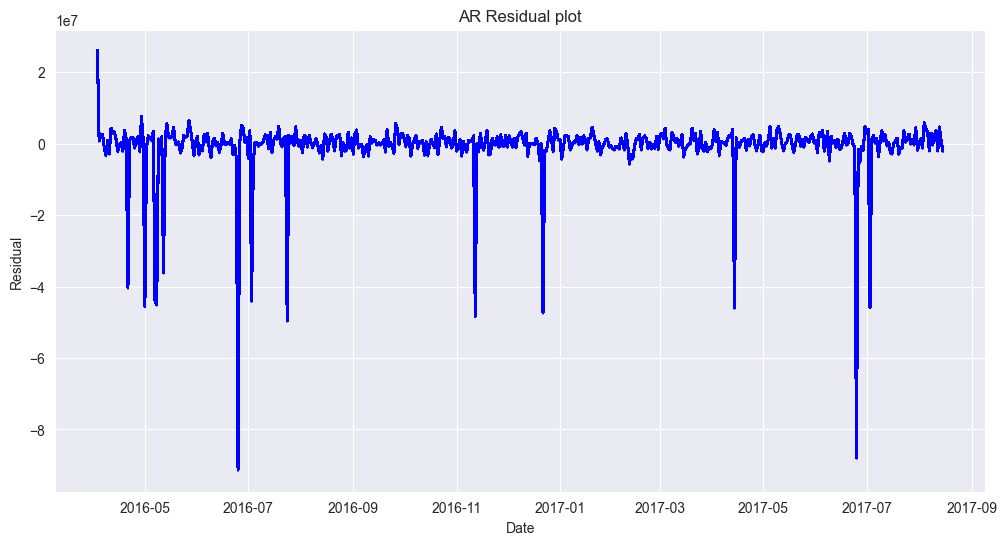

In [187]:
# plot the residual plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the residual data
plt.plot(eval.index, (AR_pred.values - eval.values), label='residuals', color='blue')

plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('AR Residual plot')
plt.grid(True)
plt.show()

A residual plot helps identify whether the AR model captures the temporal dependencies in the data effectively. we can see that residuals are distributed relatively evenly around zero, with no apparent patterns or trends.Points above the zero line represent cases where the model underestimates the actual values. In other words, the observed values are higher than what the model predicted. Points below the zero line represent cases where the model overestimates the actual values. The observed values are lower than the model's predictions.This suggest that the model may need improvement.

SARIMA MODEL

An SARIMA (Seasonal AutoRegressive Integrated Moving Average) model is a time series forecasting model that captures both autoregressive (AR), differencing (I), and moving average (MA) components, along with seasonality.

In [188]:
# Define the SARIMA model parameters
p = 1  # AR order
d = 1  # Differencing order
q = 1  # MA order
P = 1  # Seasonal AR order
D = 1  # Seasonal differencing order
Q = 1  # Seasonal MA order
s = 12  # Seasonal period (e.g., 12 for monthly data)

# Create the SARIMA model
sarima_model = sm.tsa.SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit= sarima_model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                 1186
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -20387.550
Date:                            Sun, 24 Sep 2023   AIC                          40785.100
Time:                                    23:10:09   BIC                          40810.437
Sample:                                         0   HQIC                         40794.655
                                           - 1186                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0009      0.043     -0.020      0.984      -0.084       0.083
ma.L1         -0.8370      0.032    -26.342      0.000      -0.899      -0.775
ar.S.L12      -0.0242      0.067     -0.362      0.717      -0.155       0.107
ma.S.L12      -0.9588      0.028    -34.698      0.000      -1.013      -0.905
sigma2      1.249e+14   5.34e-16   2.34e+29      0.000    1.25e+14    1.25e+14
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):           1078387.73
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             9.63
Prob(H) (two-sided):                  0.00   Kurtosis:                       150.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+44. Standard errors may be unstable.
"""

In [189]:
# make predictions on the eval data
SARIMA_pred = model_fit.predict(start=len(train),
                      end=len(train)+len(eval)-1,
                      type = 'levels'
                      )

In [190]:
# evaluate our models
mse= mean_squared_error(eval, SARIMA_pred)
msle=mean_squared_log_error(eval, SARIMA_pred)
rmse= np.sqrt(mean_squared_error(eval, SARIMA_pred)).round(2)
rmsle= np.sqrt(mean_squared_log_error(eval, SARIMA_pred)).round(2)

results=pd.DataFrame([['SARIMA',mse, msle, rmse, rmsle]], columns= ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results

,Model,MSE,MSLE,RMSE,RMSLE
0,SARIMA,1.147016e+14,0.034191,10709882.75,0.18


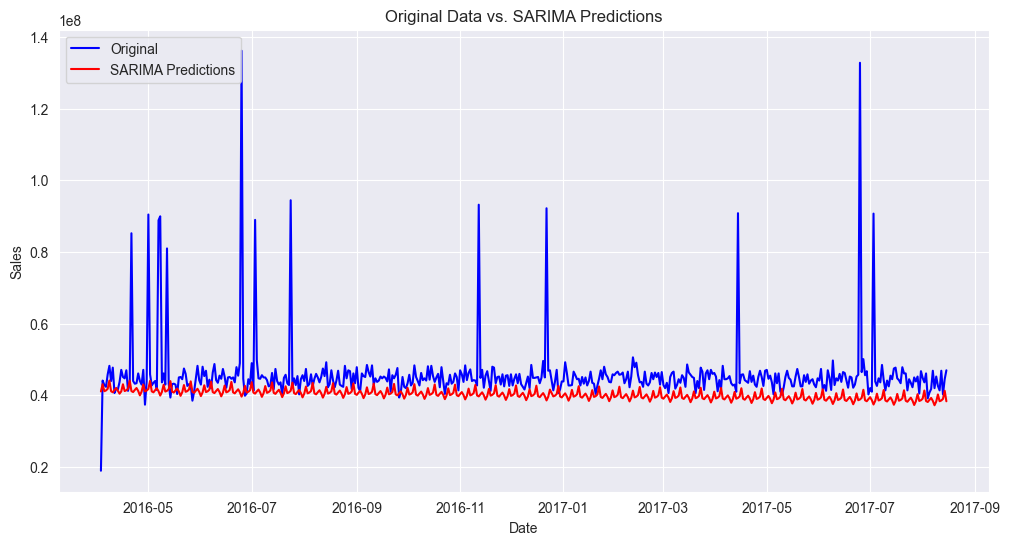

In [191]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the original data
plt.plot(eval.index, eval.values, label='Original', color='blue')

# Plot the SARIMA predictions
plt.plot(eval.index, SARIMA_pred, label='SARIMA Predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Original Data vs. SARIMA Predictions')
plt.legend()
plt.grid(True)

plt.show()

The RMSLE value of 0.18 means that, on average, the SARIMA model's predictions have a relatively low logarithmic error compared to the actual values. It suggests that the SARIMA model is making predictions that are reasonably close to the true values, with a moderate amount of error. From the visualization, we can see that the predicticed sales are slightly deviating from the actual values. This implies that there is need to improve the model.

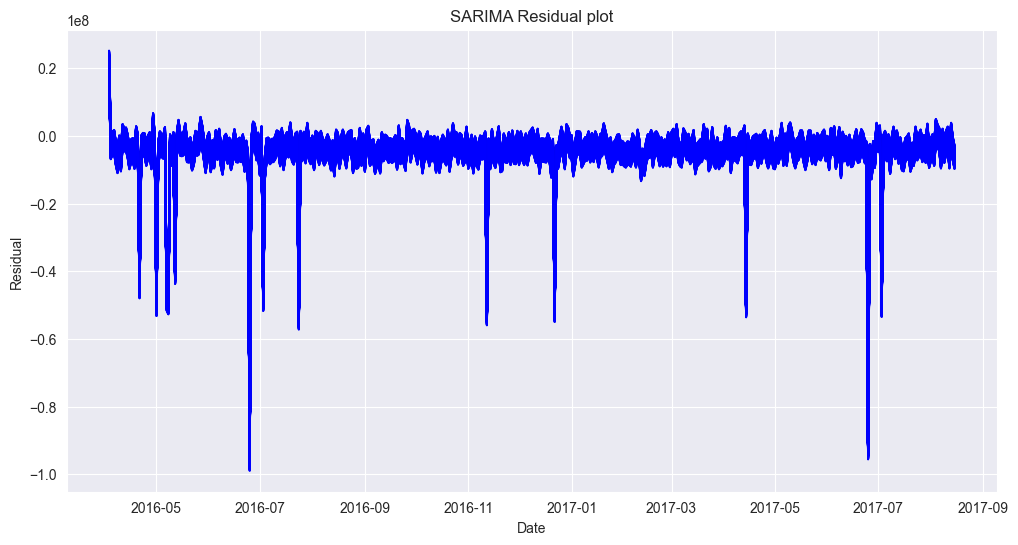

In [192]:
# plot the residual plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the residual data
plt.plot(eval.index, (SARIMA_pred.values - eval.values), label='residuals', color='blue')

plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('SARIMA Residual plot')
plt.grid(True)
plt.show()

we can see that residuals are distributed relatively evenly around zero, with no apparent patterns or trends.Points above the zero line represent cases where the model overestimates the actual values while points below the zero line represent cases where the model underestimates the actual values.Generally, the randomness of residuals and its even ditribution around zero suggests that the SARIMA model is a good fit for the data, and the RMSLE of 0.18 is reflective of a well-performing model. A lower RMSLE indicates better model performance.

ARIMA

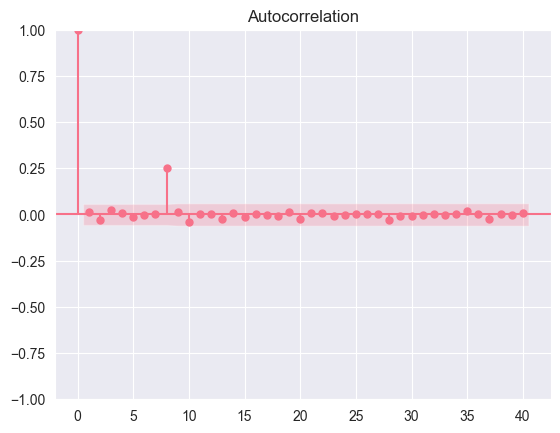

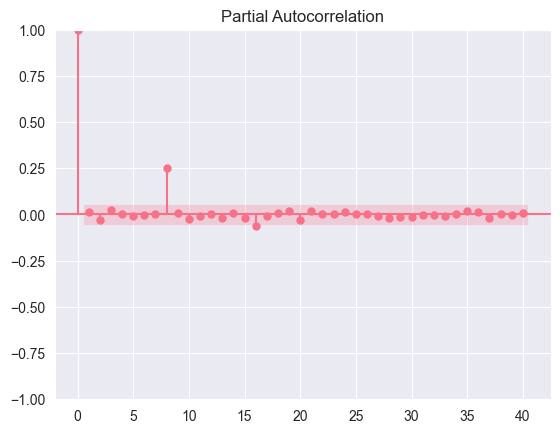

In [193]:
# Determine the order of the ARIMA model (p, d, q) based on ACF and PACF plots
# Plot ACF and PACF
plot_acf(train, lags=40)
plot_pacf(train, lags=40)
plt.show()

Identifying d (Differencing Order):

If the ACF plot shows a slow decay and remains significant at higher lags, your data may need differencing (d) to become stationary. Check the number of differences required to achieve stationarity. This is typically the number of times you need to difference the data until it becomes stationary. Use the ADF (Augmented Dickey-Fuller) test for stationarity.

Identifying p (AR Order):

For the PACF plot, look for significant spikes at lags before they drop off to insignificance. These spikes indicate the order of the autoregressive (AR) component (p). If the PACF plot cuts off after p lags, this suggests that the AR term should be set to p. In other words, p is the lag value where the PACF sharply drops to zero.

Identifying q (MA Order):

For the ACF plot, look for significant spikes at lags before they drop off to insignificance. These spikes indicate the order of the moving average (MA) component (q). If the ACF plot cuts off after q lags, this suggests that the MA term should be set to q. In other words, q is the lag value where the ACF sharply drops to zero.

we used a one order difference to make the data stationary, hence d=1
both ACF and PACF sharply drops to zero at lag 9

In [194]:
# Based on the plots, choose the order (p, d, q)
p, d, q = (9, 1, 9)  

# Build and train the ARIMA model
model = sm.tsa.ARIMA(train, order=(p, d, q))
results = model.fit()

In [195]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1186
Model:                 ARIMA(9, 1, 9)   Log Likelihood              -20315.897
Date:                Sun, 24 Sep 2023   AIC                          40669.795
Time:                        23:10:34   BIC                          40766.267
Sample:                             0   HQIC                         40706.158
                               - 1186                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7624      0.478     -1.596      0.110      -1.699       0.174
ar.L2         -0.0371      0.281     -0.132      0.895      -0.587       0.513
ar.L3         -0.0997      0.300     -0.333      0.739      -0.687       0.488
ar.L4          0.0310      0.369      0.084      0.933      -0.691       0.753
ar.L5         -0.0774      0.455     -0.170      0.865      -0.970       0.815
ar.L6         -0.0077      0.377     -0.020      0.984      -0.746       0.731
ar.L7         -0.0321      0.316     -0.102      0.919      -0.652       0.588
ar.L8          0.0724      0.241      0.301      0.763      -0.399       0.544
ar.L9          0.2234      0.110      2.033      0.042       0.008       0.439
ma.L1         -0.2169      0.480     -0.452      0.651      -1.158       0.724
ma.L2         -0.7468      0.503     -1.484      0.138      -1.733       0.239
ma.L3          0.0853      0.310      0.275      0.784      -0.523       0.693
ma.L4         -0.1147      0.405     -0.283      0.777      -0.908       0.678
ma.L5          0.0670      0.413      0.162      0.871      -0.743       0.877
ma.L6         -0.0624      0.377     -0.166      0.868      -0.801       0.676
ma.L7          0.0394      0.378      0.104      0.917      -0.702       0.781
ma.L8          0.1447      0.246      0.589      0.556      -0.337       0.626
ma.L9         -0.1898      0.257     -0.738      0.461      -0.694       0.315
sigma2      4.763e+13   5.13e-13   9.28e+25      0.000    4.76e+13    4.76e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):           2173167.65
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            12.49
Prob(H) (two-sided):                  0.09   Kurtosis:                       211.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.76e+39. Standard errors may be unstable.
"""

In [196]:
# make predictions on the eval data
ARIMA_pred=results.predict(start=len(train),
                      end=len(train)+len(eval)-1,
                      type = 'levels'
                      )

In [197]:
# evaluate our models
mse= mean_squared_error(eval, ARIMA_pred)
msle=mean_squared_log_error(eval, ARIMA_pred)
rmse= np.sqrt(mean_squared_error(eval, ARIMA_pred)).round(2)
rmsle= np.sqrt(mean_squared_log_error(eval, ARIMA_pred)).round(2)

results=pd.DataFrame([['ARIMA',mse, msle, rmse, rmsle]], columns= ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results

,Model,MSE,MSLE,RMSE,RMSLE
0,ARIMA,8.299068e+13,0.019365,9109921.94,0.14


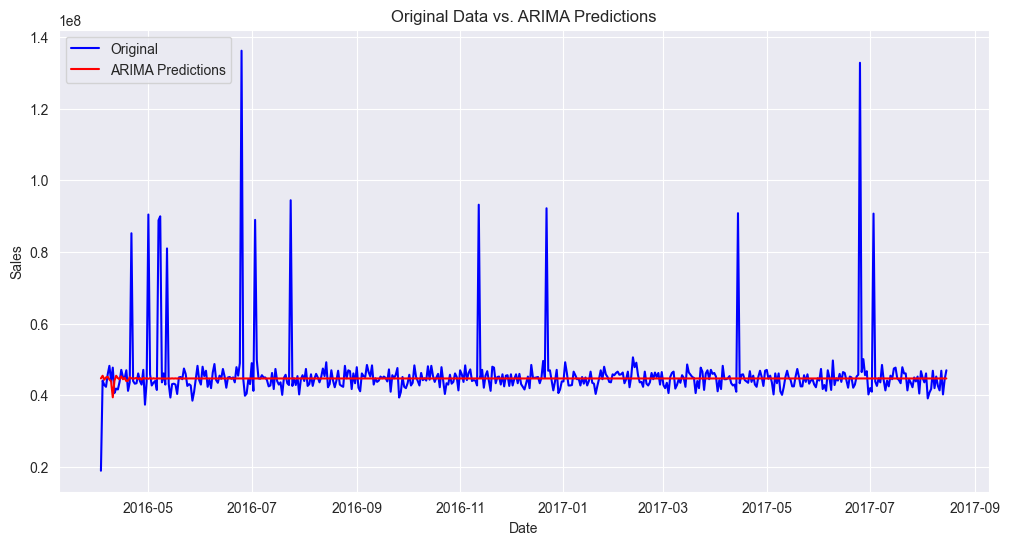

In [198]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the original data
plt.plot(eval.index, eval.values, label='Original', color='blue')

# Plot the ARIMA predictions
plt.plot(eval.index, ARIMA_pred, label='ARIMA Predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Original Data vs. ARIMA Predictions')
plt.legend()
plt.grid(True)

plt.show()

The ARIMA model is providing predictions that are reasonably close to the actual values. An RMSLE of 0.14 indicates that the model's predictions are on average within a relatively small percentage error of the actual values. An RMSLE of 0.14 means that the model's predictions deviate from the actual values by around 14% on average when considering the logarithm of the values. Hence, there is need to refine the model to improve the RMSLE.

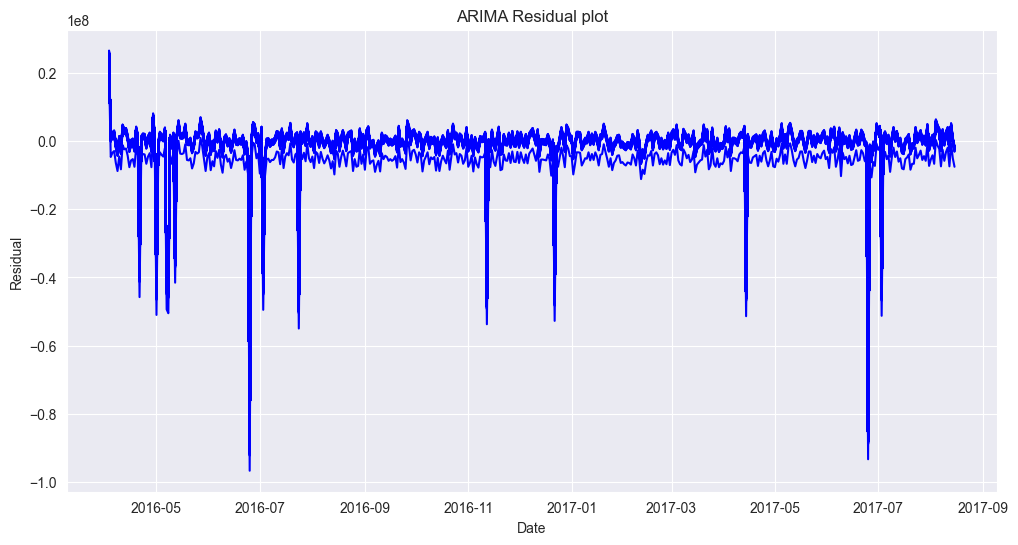

In [199]:
# plot the residual plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the residual data
plt.plot(eval.index, (ARIMA_pred.values - eval.values), label='residuals', color='blue')

plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('ARIMA Residual plot')
plt.grid(True)
plt.show()

Data conversion due to memory error

In [200]:
# Get the current data types of all columns
current_dtypes = train_test.dtypes

# Find columns that are not already of type float32 and are not categorical (categorical columns have dtype 'object')
columns_to_convert = current_dtypes[(~current_dtypes.isin(['float32'])) & (~current_dtypes.isin(['object']))].index.tolist()

# Convert the selected columns to float32 in train, eval and test datasets
train_test[columns_to_convert] = train_test[columns_to_convert].astype('float32')

eval_test[columns_to_convert] = eval_test[columns_to_convert].astype('float32')

final_test1[columns_to_convert] = final_test1[columns_to_convert].astype('float32')

Random Forest

In [ ]:
#Copy of features for train and evaluation set
X_train_set = train_test.drop(columns='sales')
X_eval_set = eval_test.drop(columns='sales')

#Copy of target for train and evaluation set

y_train_set = train_test['sales']
y_eval_set = eval_test['sales']

In [ ]:
# Create an instance of the RandomForestRegressor
rf = RandomForestRegressor(random_state=42) 
rf.fit(X_train_set, y_train_set)

rf_pred = rf.predict(X_eval_set)

In [ ]:
#Copy of predicted sales
rf_pred_c = rf_pred
#change datatype to "float32" due to memory challenges
rf_pred_c = rf_pred_c.astype('float32')

In [ ]:
mse = mean_squared_error(y_eval_set, rf_pred_c)
rmse = mse ** 0.5  # Calculate RMSE
rmsle = np.sqrt(mean_squared_log_error(y_eval_set, rf_pred_c))
print("MSE:", mse)
print("RMSE:", rmse)
print("RMSLE:", rmsle)

In [ ]:
# plot predictions
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the original data
plt.plot(y_eval_set.index, y_eval_set.values, label='Original', color='blue')

# Plot the Random Forest predictions
plt.plot(y_eval_set.index, rf_pred_c, label='Random Forest Predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Original Data vs. Random Forest Predictions')
plt.legend()
plt.grid(True)

plt.show()

The model's predictions are very close to the actual values, and the fit is nearly perfect. The red line (predicted values) follows the blue line (actual values) throughout the entire time series. The low RMSLE 0f 0.028 suggests that the Random Forest model has effectively captured the underlying patterns, seasonality, and trends in the sales data. It means that the model's predictions are not only close to the actual values but also in the same relative proportion as the original data.

In [ ]:
# plot the residual plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the residual data
plt.plot(y_eval_set.index, (rf_pred_c - y_eval_set.values), label='residuals', color='blue')

plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Random Forest Residual plot')
plt.legend()
plt.grid(True)
plt.show()

The residuals are centered around the zero line on the vertical axis. the residuals have a mean close to zero, indicating that, on average, the model neither overpredicts nor underpredicts. There is a random scatter of points around the horizontal axis. This suggests that the model is capturing the underlying data patterns well.

In [ ]:
rf_importance = rf.feature_importances_
# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_train_set.columns, 'Importance': rf_importance})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(15)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

The graph shows the contribution of each input variable (feature) in predicting the target variable or sales. Above features are the top 15 features that are most influential in making predictions, with store number, product_grocery 1, oil prices, day of the month, month and product bevarages being the top contributors in predicting sales using the random forest model.

Decision Tree Regressor

In [ ]:
# Create an instance of the Decision Trees
dt= DecisionTreeRegressor(random_state=42) 
dt.fit(X_train_set, y_train_set)
dt_pred = dt.predict(X_eval_set)

In [ ]:
#Copy of predicted sales
dt_pred_c = dt_pred
#change datatype to "float32" due to memory challenges
dt_pred_c = dt_pred_c.astype('float32')

In [ ]:
mse = mean_squared_error(y_eval_set, dt_pred_c)
rmse = mse ** 0.5   # Calculate RMSE
rmsle = np.sqrt(mean_squared_log_error(y_eval_set, dt_pred_c))
print("MSE:", mse)
print("RMSE:", rmse)
print("RMSLE:", rmsle)

In [ ]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the original data
plt.plot(y_eval_set.index, y_eval_set.values, label='Original', color='blue')

# Plot the Decision Trees predictions
plt.plot(y_eval_set.index, dt_pred_c, label='Decision Tree Predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Original Data vs. Decision Tree Predictions')
plt.legend()
plt.grid(True)

plt.show()

The Decision Trees model produces predictions with an RMSLE (Root Mean Squared Logarithmic Error) of  0.031, it indicates that the model's predictions are quite close to the actual values,very close to the Random Forest model with an RMSLE of 0.028. While the fit is close, there are some few instances where the predictions deviate slightly from the actual values.Generally, the Decision Trees model has captured most of the important trends, seasonality, and variations in the data. However, there may be some occasional deviations from the true values.

In [ ]:
# plot the residual plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the residual data
plt.plot(y_eval_set.index, (dt_pred_c - y_eval_set.values), label='residuals', color='blue')

plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Decision Trees Residual plot')
plt.grid(True)

plt.show()

we can observe that the residuals are centered around the zero line on the vertical axis. Ideally, the residuals should have a mean close to zero, indicating that, on average, the model neither overpredicts nor underpredicts. Also the random scatter of points around the horizontal axis suggests that the model is capturing the underlying data patterns well.

In [ ]:
dt_importance = dt.feature_importances_
# Create a DataFrame to store feature names and their importances
feature_importance_dt = pd.DataFrame({'Feature': X_train_set.columns, 'Importance': dt_importance})

# Sort the DataFrame by importance
feature_importance_dt = feature_importance_dt.sort_values(by='Importance', ascending=False).head(15)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_dt)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

The graph shows the contribution of each input variable (feature) in predicting the target variable or sales. Above features are the top 15 features that are most influential in making predictions, with store number, product_grocery 1, oil prices, day of month, and product_bevarages ranking as the top contributors in predicting sales using Decision tree model.

Model Comparison

In [ ]:
# Create an empty list to store the results
results_list = []
	
# Model 1 results
model1_results = ['ARIMA', 8.299068e+13, 0.019365, 9109921.94, 0.14]
results_list.append(model1_results)

# Model 2 results
model2_results = ['SARIMA', 1.147016e+14, 0.034191, 10709882.75, 0.18]
results_list.append(model2_results)

# Model 3 results
model3_results = ['Decision Trees', 4189206.5, '', 2046.755114809781 , 0.03063846]
results_list.append(model3_results)

# Model 4 results
model4_results = ['Random Forest', 2424219.8,'', 1556.9906069080828,  0.02862653]
results_list.append(model4_results)

# Model 5 results
model5_results = ['AR', 8.239443e+13, 0.019181, 9077137.82,	0.14]
results_list.append(model5_results)

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list, columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])

# Print the combined results
print(results_df)

Hyperparameter tuning

Tuning Arima

Using a parameter grid to search for the best combination of order components (p, d, q) in an ARIMA model is a common approach for model selection and hyperparameter tuning.

Defined a parameter grid through a process of grid search, where you systematically test different combinations of orders and select the one that yields the best performance on a validation dataset.

In [ ]:
# Define a parameter grid
param_grid = {
    'order': [(0, 1, 1), (1, 1, 1), (1, 1, 2), (2, 1, 1), (2, 1, 2)],
}

best_rmsle = 0.14
best_model = None

# Perform grid search
for params in param_grid['order']:
    model = sm.tsa.ARIMA(train, order=params)
    A_model=model.fit()

    # Use 'forecast' to predict future values
    forecast = A_model.forecast(steps=len(eval))

    # extract the point forecasts
    y_pred = forecast

    # Evaluate your predictions
    mse = mean_squared_error(eval, y_pred)
    msle=mean_squared_log_error(eval, y_pred)
    rmse= np.sqrt(mean_squared_error(eval, y_pred)).round(2)
    rmsle= np.sqrt(mean_squared_log_error(eval, y_pred)).round(2)
    if rmsle < best_rmsle:
        best_rmsle = rmsle
        best_model = model

# The best model and hyperparameters
print(f"Best_rmsle: {best_rmsle}")
print(f"Best Hyperparameters: {params}")

Tuning SARIMA Model

Created a parameter grid with different combinations of p, d, q, P, D, Q, and s, and performed a grid search 

In [ ]:
#from sklearn.model_selection import ParameterGrid


# Define parameter grid
param_grid = {
    'p': [1,2],
    'd': [1],
    'q': [1,2],
    'P': [1,2],
    'D': [1],
    'Q': [1,2],
    's': [12]  # Seasonal period (e.g., 12 for monthly data)
}

best_rmsle = 0.18
best_params = None

for params in ParameterGrid(param_grid):
    # Fit SARIMA model with current hyperparameters
    model = sm.tsa.SARIMAX(train, order=(params['p'], params['d'], params['q']),
                    seasonal_order=(params['P'], params['D'], params['Q'], params['s']))
    results = model.fit()

    # Make predictions on validation data
    SA_pred = results.predict(start=len(train),
                      end=len(train)+len(eval)-1,
                      type = 'levels'
                      )

    # Calculate RMSE (or another evaluation metric) for validation
    mse = mean_squared_error(eval, SA_pred)
    msle=mean_squared_log_error(eval, SA_pred)
    rmse= np.sqrt(mean_squared_error(eval, SA_pred)).round(2)
    rmsle= np.sqrt(mean_squared_log_error(eval, SA_pred)).round(2)

    # Check if the current RMSE is better than the best RMSE found so far
    if rmsle < best_rmsle:
        best_rmsle = rmsle
        best_params = params

print("Best hyperparameters:", best_params)
print("Best RMSLE:", best_rmsle)

Very slight improvement of model's rmsle from 0.18 to 0.17

In [ ]:
results_df

Based on the above metrics, the "Random Forest" model has the lowest RMSLE (0.028627), followed closely by the "Decision Trees" model (0.030638). These models also have the lowest RMSE values. Generally, lower RMSLE and RMSE values indicate better model performance.

However, it's essential to consider other factors when choosing the best model:

Model Interpretability: Decision Trees tend to be more interpretable than complex ensemble methods like Random Forest. If interpretability is crucial for your problem, you might favor Decision Trees.

Computational Efficiency: Decision Trees are computationally less intensive compared to Random Forest, which can be a consideration if you need a model that can be trained and deployed quickly.

Overfitting: Random Forest is less prone to overfitting compared to Decision Trees. If your dataset is relatively small or noisy, Random Forest might generalize better.

Feature Importance: If you need insights into feature importance, Random Forest provides a built-in mechanism to assess feature importance, which can be valuable for understanding the drivers of predictions

Make predictions on Test Dataset

In [ ]:
#Drop the sales column that was created in the test dataset to handle challenges with preprocessing

final_testdf = final_test1.drop(columns='sales')

In [ ]:
# Make predictions on the test data
test_predictions = rf.predict(final_testdf)
test_predictions

Saving the model
Pickle is the standard way of serializing objects in Python. we will use the pickle operation to serialize our machine learning algorithm and save the serialized format to a file

In [ ]:
# saving our best model
sales_pred_model = RandomForestRegressor(random_state=42)

# Save the model to a file using pickle
with open('sales_pred_model.pkl', 'wb') as model_file:
    pickle.dump(sales_pred_model, model_file)

In [ ]:
# Load the model from the saved file
with open('sales_pred_model.pkl', 'rb') as model_file:
    loaded_sales_model = pickle.load(model_file)

# Now we can use loaded_sales_model for predictions and evaluation

In [ ]:
# load sample submission
sample_submission = pd.read_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\sample_submission.csv')
sample_submission.head()


In [ ]:
# Convert the test prediction array to a DataFrame with a column name 'Prediction'
df_prediction = pd.DataFrame({'Prediction': test_predictions})

In [ ]:
submission_df = pd.concat([sample_submission, df_prediction], axis=1)
submission_df.head()

In [ ]:
submission_df.drop('sales', axis=1, inplace=True)

In [ ]:
submission_df.head(3)

In [ ]:
# rename prediction to sales
submission_df.rename(columns={'Prediction':'sales'}, inplace=True)
submission_df.head(10)

Export Key Components

Here we export the important ML objects that will be used to develop an app: encoder, models e.t.c

In [ ]:
# define the components to be exported 
components= {
    'models': sales_pred_model,
    'pipeline' : preprocessor

}

In [ ]:
#This is the directory to save the components and requirements
# create a directory named "export"
!mkdir export

Path to the destination directory

In [ ]:
destination = r'C:\Users\WORLDAX COMPUTERS\Python Projects\STREAMLIT_PROJECT\export'

#construct the full file path
file_path = os.path.join(destination, 'ml.pkl')

#Save the components object as a pickled file
with open(file_path, 'wb') as f:
    pickle.dump(components, f)

In [ ]:
# save the list of installed Python packages along with their versions into a text file

!pip freeze > export/requirements.txt

Above code creates a text file named "requirements"inside the "export" directory.

File is useful for creating the same environment on another system or sharing the requirements of this project with others.